In [1]:
import json
import cv2 as cv
import pickle as pkl
from typing import Dict, List
import numpy as np
import torch
from matplotlib import pyplot as plt
import os, sys
import librosa
import shutil 
import csv

from scipy import stats, spatial, ndimage
sys.path.insert(0, '/Users/evanpan/Documents/GitHub/EvansToolBox/Utils')
sys.path.insert(0, '/Users/evanpan/Documents/GitHub/Gaze_project')
sys.path.insert(0, "C:/Users/evansamaa/Documents/GitHub/EvansToolBox/Utils")
sys.path.insert(0, "C:/Users/evansamaa/Documents/GitHub/Gaze_project")
sys.path.insert(0, "C:/Users/evan1/Documents/GitHub/EvansToolBox/Utils")
sys.path.insert(0, "C:/Users/evan1/Documents/GitHub/Gaze_project")
sys.path.insert(0, "/scratch/ondemand27/evanpan/EvansToolBox/Utils")
sys.path.insert(0, "/scratch/ondemand27/evanpan/Gaze_project")
from Signal_processing_utils import intensity_from_signal, pitch_from_signal, sparse_key_smoothing, laplacian_smoothing
from Speech_Data_util import Sentence_word_phone_parser
from prototypes.InputDataStructures import Dietic_Conversation_Gaze_Scene_Info, AgentInfo_time_varying, AgentInfo_final
from prototypes.MVP.MVP_static_saliency_list import ObjectBasedFixSaliency
from prototypes.MVP.MVP_Aversion_saliency_list import AversionSignalDrivenSaliency, CTSAversionSignalDrivenSaliency
from prototypes.MVP.MVP_look_at_point_planner import HabituationBasedPlanner, RandomPlanner, PartnerHabituationPlanner
from prototypes.MVP.MVP_eye_head_driver import HeuristicGazeMotionGenerator
from prototypes.MVP.MVP_Aversion_saliency_list import Base_Static_Saliency_List
from prototypes.EyeCatch.Saccade_model_with_internal_model import *
from prototypes.Gaze_aversion_prior.Heuristic_model import *
from prototypes.Boccignone2020.Gaze_target_planner import Scavenger_based_planner
from prototypes.Boccignone2020.Improved_gaze_target_planner import Scavenger_planner_with_nest, Scavenger_planner_simple 
from prototypes.JaliNeck.JaliNeck import NeckCurve
from prototypes.Gaze_aversion_prior.Ribhav_model import predict_aversion
from prototypes.Gaze_aversion_prior.Evan_model import Aversion111Prior
from prototypes.InputDataStructures import AgentInfo, TurnTakingData
from prototypes.MVP.MVP_gaze_path_planner import Responsive_planner_Listener_wonders, Responsive_planner_Differnet_Targets, Responsive_planner_ThreeParty, Responsive_planner_simple, Responsive_planner_no_heuristics, Responsive_planner_no_Gaze_deploy, Responsive_planner_React_to_gaze_no_Gaze_deploy
import pickle
import math
import re
import string
from datetime import datetime, timezone
import scipy.stats as ss
from Signal_processing_utils import interpolate1D, runEuro, pad_arrays
from scipy.interpolate import interp1d
from Geometry_Util import directions_from_rotation_angles
from Video_analysis_utils import get_wav_from_video

%load_ext autoreload
%autoreload 1

%aimport prototypes.InputDataStructures
%aimport Speech_Data_util
%aimport Signal_processing_utils
%aimport Geometry_Util
%aimport prototypes.MVP.MVP_static_saliency_list
%aimport prototypes.EyeCatch.Saccade_model_with_internal_model
%aimport prototypes.InputDataStructures
%aimport prototypes.Jin2019.EyeHeadDecomposition
%aimport prototypes.Optimization_based_head_eye_seperator.Baseline_optimization
%aimport prototypes.Boccignone2020.Improved_gaze_target_planner
%aimport prototypes.MVP.MVP_gaze_path_planner
%aimport prototypes.JaliNeck.JaliNeck
%aimport prototypes.Gaze_aversion_prior.Evan_model
def get_beats(audio_energy):
    beat_ts = np.arange(0, audio_energy.shape[0]) / 25
    daudio_dt = dx_dt(audio_energy)
    Dm = 0.2
    DM = 0.7
    DM_frame = math.floor(DM / (beat_ts[1] - beat_ts[0]))
    energy_interp = interp1d(beat_ts, audio_energy, bounds_error=False)
    # iterative find audio onset between 0.2 and 0.6 seconds to identify beats
    beats = [[0, False]] # start with a pseudo beat
    for i in range(0, audio_energy.shape[0]):
        if daudio_dt[i] > 5:
            current_beat_t = beat_ts[i]
            if current_beat_t - beat_ts[beats[-1][0]] <= Dm:
                continue
            if current_beat_t - beat_ts[beats[-1][0]] >= DM:
                # these are stored as integer indexes
                start = beats[-1][0]
                end = i
                counter = start + DM_frame
                while counter < end:
                    beats.append([counter, False])
                    counter = counter + DM_frame
            beats.append([i, True])
    beats_arr = []
    for i in range(0, len(beats)):
        if beats[i][1]:
            beats_arr.append([beat_ts[beats[i][0]], audio_energy[beats[i][0]]])
    beats_arr = np.array(beats_arr)
    return beats_arr
def get_beats_from_audio(audio, sr):
    fps = 50
    audio_energy = intensity_from_signal(audio, int(sr/fps))
    beat_ts = np.arange(0, audio_energy.shape[0]) / fps
    daudio_dt = dx_dt(audio_energy)
    Dm = 0.2
    DM = 0.7
    DM_frame = math.floor(DM / (beat_ts[1] - beat_ts[0]))
    energy_interp = interp1d(beat_ts, audio_energy, bounds_error=False)
    # iterative find audio onset between 0.2 and 0.6 seconds to identify beats
    beats = [[0, False]] # start with a pseudo beat
    for i in range(0, audio_energy.shape[0]):
        if daudio_dt[i] > 5:
            current_beat_t = beat_ts[i]
            if current_beat_t - beat_ts[beats[-1][0]] <= Dm:
                continue
            if current_beat_t - beat_ts[beats[-1][0]] >= DM:
                # these are stored as integer indexes
                start = beats[-1][0]
                end = i
                counter = start + DM_frame
                while counter < end:
                    beats.append([counter, False])
                    counter = counter + DM_frame
            beats.append([i, True])
    beats_arr = []
    for i in range(0, len(beats)):
        if beats[i][1]:
            beats_arr.append([beat_ts[beats[i][0]], audio_energy[beats[i][0]]])
    beats_arr = np.array(beats_arr)
    return beats_arr
def dispersion_filtering(x, y, dispersion_threshold = 6, duraiton_threshold=0.3):
    start = 0
    window = []
    fps = int(np.round(1/(x[1] - x[0])))
    duration_threshold_frames = np.ceil(duraiton_threshold * fps)
    
    def dispersion(arr):
        # input is a 2d array
        disp = np.max(arr[:, 0]) - np.min(arr[:, 0]) + np.max(arr[:, 1]) - np.min(arr[:, 1])
        return disp

    fixations = []
    fixations_intervals = []
    
    # while there are still points
    while int(start+duration_threshold_frames) < y.shape[0]:
        # initialize a window:
        window = list(range(int(start), int(start+duration_threshold_frames)))
        start = start + duration_threshold_frames
        disp = dispersion(y[window])
        while disp <= dispersion_threshold:
            disp = dispersion(y[window])
            if window[-1]+1 < y.shape[0]:
                window.append(window[-1]+1)
            start = start + 1
            if start >= y.shape[0]:
                break
        # if the current set of points never fit the duration criteria
        if len(window) <= duration_threshold_frames:
            start = start + 1
        # otherwise note it as fixations
        else:
            centroid = np.mean(y[window], axis=0)
            duration = (window[-1] - window[0]) / fps
            fixations.append([centroid[0], centroid[1], duration])
            fixations_intervals.append([window[0], window[-1]])
    fixations = np.array(fixations)
    return fixations, fixations_intervals

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [2]:
import numpy as np
import whisper_timestamped
import librosa
import python_speech_features as psf
import os
import json
import sys
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
import pickle as pkl
from scipy.special import softmax
from torchmetrics.classification import BinaryF1Score, F1Score
from torchmetrics.classification import Accuracy, Precision, Recall
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from scipy.interpolate import interp1d
sys.path.insert(0, '/Users/evanpan/Documents/GitHub/EvansToolBox/Utils')
sys.path.insert(0, '/Users/evanpan/Desktop/openpose/python/')
sys.path.insert(0, '/scratch/ondemand27/evanpan/EvansToolBox/Utils/')
sys.path.insert(0, '/scratch/ondemand27/evanpan/Gaze_project/')

from Signal_processing_utils import intensity_from_signal
from prototypes.Gaze_aversion_prior.Evan_model import Aversion111Prior
from Dataset_Util.dataloader import *
import copy
import cv2 as cv
%load_ext autoreload
%autoreload 1
%aimport prototypes.Gaze_aversion_prior.Evan_model
%aimport Signal_processing_utils
%aimport Dataset_Util.dataloader


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
class Explicit_context_GazePredictionModel(nn.Module):
    def __init__(self, config):
        torch.set_default_tensor_type(torch.DoubleTensor)
        # initialize model
        super(Explicit_context_GazePredictionModel, self).__init__()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.activation = nn.Sigmoid()
        self.num_layers = config["num_layers"]
        self.config = config
        # the feature of each speaker are encoded with a separate Linear Layer
        self.input_layer_self = nn.Linear(int(config["input_dims"]/2 - 6), config["input_layer_out"])
        self.input_layer_other = nn.Linear(int(config["input_dims"]/2 - 6), config["input_layer_out"])
        
        # the Recurrent Layer will take care of the next step
        self.lstm_hidden_dims = config["lstm_output_feature_size"]
        self.num_lstm_layer = config["lstm_layer_num"]
        self.frames_ahead = config["frames_ahead"]
        self.frames_behind = config["frames_behind"]
        self.lstm = nn.LSTM(2 * (config["input_layer_out"] + 6) * (self.frames_ahead + self.frames_behind + 1), 
                            self.lstm_hidden_dims, 
                            self.num_lstm_layer, 
                            batch_first=True)
        self.h_0_0 = torch.randn(self.num_lstm_layer, self.lstm_hidden_dims).to(self.device)
        self.c_0_0 = torch.randn(self.num_lstm_layer, self.lstm_hidden_dims).to(self.device)        
        self.h_0_1 = torch.randn(self.num_lstm_layer, self.lstm_hidden_dims).to(self.device)
        self.c_0_1 = torch.randn(self.num_lstm_layer, self.lstm_hidden_dims).to(self.device)
        self.h_0_0 = torch.nn.Parameter(self.h_0_0)
        self.h_0_1 = torch.nn.Parameter(self.h_0_1)
        self.c_0_0 = torch.nn.Parameter(self.c_0_0)
        self.c_0_1 = torch.nn.Parameter(self.c_0_1)


        self.bn_layer_1 = nn.BatchNorm1d(config["output_layer_1_hidden"], track_running_stats=False)
        self.bn_layer_2 = nn.BatchNorm1d(config["output_layer_2_hidden"], track_running_stats=False)
        # output layers
        self.output_layer_1 = nn.Linear(self.lstm_hidden_dims, config["output_layer_1_hidden"])
        self.output_layer_1 = nn.Sequential(self.output_layer_1, self.activation, nn.Dropout(self.config["dropout"]))
        self.output_layer_2 = nn.Linear(config["output_layer_1_hidden"], config["output_layer_2_hidden"])
        self.output_layer_2 = nn.Sequential(self.output_layer_2, self.activation, nn.Dropout(self.config["dropout"]))
        self.output_layer_3 = nn.Linear(config["output_layer_2_hidden"], config["output_layer_3_hidden"])
        self.output_layer_3 = nn.Sequential(self.output_layer_3)

        # audio_filler = torch.tensor([[[-36.04365338911715,0.0,0.0,0.0,0.0,0.0,-3.432169450445466e-14,0.0,0.0,0.0,9.64028691651994e-15,0.0,0.0,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715]]]).to(self.device)
        # text_filler = torch.ones([1, 1, 772]).to(self.device) * -15
        # text_filler[:, :, -4:] = 0
        # self.filler = torch.concat([audio_filler, text_filler], axis=2)
    def concate_frames(self, input_feature):
        # here I expect the 
        padding_front = torch.zeros([input_feature.shape[0], self.frames_ahead, input_feature.shape[2]]).to(self.device)
        padding_back = torch.zeros([input_feature.shape[0], self.frames_behind, input_feature.shape[2]]).to(self.device)
        padded_input_audio = torch.cat([padding_front, input_feature, padding_back], dim=1)
        window_audio = []
        for i in range(0, input_feature.shape[1]):
            window_count = i + self.frames_ahead
            current_window = padded_input_audio[:, window_count-self.frames_ahead:window_count+self.frames_behind+1]
            s = current_window.shape
            current_window = current_window.view((s[0], s[1] * s[2]))
            current_window = torch.unsqueeze(current_window, 1)
            window_audio.append(current_window)
        rtv = torch.cat(window_audio, dim=1)
        return rtv
    def forward(self, input_feature, initial_state):
        feature_size = int(input_feature.size()[2] / 2)
        mod_audio_self = input_feature[:, :, :feature_size]
        mod_audio_other = input_feature[:, :, feature_size:]
        
        text_feature_self = mod_audio_self[:, :, :6]
        mod_audio_self = mod_audio_self[:, :, 6:]
        text_feature_other = mod_audio_other[:, :, :6]
        mod_audio_other = mod_audio_other[:, :, 6:]
        x1 = self.activation(self.input_layer_self(mod_audio_self))
        x2 = self.activation(self.input_layer_other(mod_audio_other))
        x1_windowed = self.concate_frames(x1)
        x2_windowed = self.concate_frames(x2)
        x_combined = torch.concat([x1_windowed, text_feature_self, x2_windowed, text_feature_other], axis=2)
        # here I'm assuming that the input_audio is of proper shape
        # initial_state's shape = [batch_size, 1]
        # self.h_0_1's shape = [num_layers, hidden_size]
        initial_state = torch.unsqueeze(initial_state, 0) # hidden state are time_step first dispite the batch_first parameter
        h_0 = initial_state * torch.unsqueeze(self.h_0_1, axis=1) + (1 - initial_state) * torch.unsqueeze(self.h_0_0, axis=1)
        c_0 = initial_state * torch.unsqueeze(self.c_0_1, axis=1) + (1 - initial_state) * torch.unsqueeze(self.c_0_0, axis=1)
        out, hidden_state = self.lstm(x_combined, (h_0, c_0))
        # bn
        x = self.activation(out)
        x = self.output_layer_1(x)
        # x has the shape (N x T x C)
        x = self.output_layer_2(x)
        x = self.output_layer_3(x)
        return x
    def load_weights(self, pretrained_dict):
    #   not_copy = set(['fc.weight', 'fc.bias'])
        model_dict = self.state_dict()
        pretrained_dict = {k: v for k, v in pretrained_dict.items()}
        model_dict.update(pretrained_dict)
        self.load_state_dict(model_dict)

class SentenceBaseline_GazePredictionModel(nn.Module):
    def __init__(self, config):
        torch.set_default_tensor_type(torch.DoubleTensor)
        # initialize model
        super(SentenceBaseline_GazePredictionModel, self).__init__()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.activation = nn.Sigmoid()
        self.num_layers = config["num_layers"]
        self.config = config
        # the feature of each speaker are encoded with a separate Linear Layer
        self.input_layer_self = nn.Linear(int(config["input_dims"]/2 - 6), config["input_layer_out"])
        self.input_layer_other = nn.Linear(int(config["input_dims"]/2 - 6), config["input_layer_out"])
        
        # the Recurrent Layer will take care of the next step
        self.lstm_hidden_dims = config["lstm_output_feature_size"]
        self.num_lstm_layer = config["lstm_layer_num"]
        self.frames_ahead = config["frames_ahead"]
        self.frames_behind = config["frames_behind"]
        self.lstm = nn.LSTM(2 * (config["input_layer_out"] + 6) * (self.frames_ahead + self.frames_behind + 1), 
                            self.lstm_hidden_dims, 
                            self.num_lstm_layer, 
                            batch_first=True)        
        # output layers
        self.output_layer_1 = nn.Linear(self.lstm_hidden_dims, config["output_layer_1_hidden"])
        self.output_layer_1 = nn.Sequential(self.output_layer_1, self.activation, nn.Dropout(self.config["dropout"]))
        self.output_layer_2 = nn.Linear(config["output_layer_1_hidden"], config["output_layer_2_hidden"])
        self.output_layer_2 = nn.Sequential(self.output_layer_2, self.activation, nn.Dropout(self.config["dropout"]))
        self.output_layer_3 = nn.Linear(config["output_layer_2_hidden"], config["output_layer_3_hidden"])
        self.output_layer_3 = nn.Sequential(self.output_layer_3)

        # audio_filler = torch.tensor([[[-36.04365338911715,0.0,0.0,0.0,0.0,0.0,-3.432169450445466e-14,0.0,0.0,0.0,9.64028691651994e-15,0.0,0.0,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715]]]).to(self.device)
        # text_filler = torch.ones([1, 1, 772]).to(self.device) * -15
        # text_filler[:, :, -4:] = 0
        # self.filler = torch.concat([audio_filler, text_filler], axis=2)
    def concate_frames(self, input_feature):
        # here I expect the 
        padding_front = torch.zeros([input_feature.shape[0], self.frames_ahead, input_feature.shape[2]]).to(self.device)
        padding_back = torch.zeros([input_feature.shape[0], self.frames_behind, input_feature.shape[2]]).to(self.device)
        padded_input_audio = torch.cat([padding_front, input_feature, padding_back], dim=1)
        window_audio = []
        for i in range(0, input_feature.shape[1]):
            window_count = i + self.frames_ahead
            current_window = padded_input_audio[:, window_count-self.frames_ahead:window_count+self.frames_behind+1]
            s = current_window.shape
            current_window = current_window.view((s[0], s[1] * s[2]))
            current_window = torch.unsqueeze(current_window, 1)
            window_audio.append(current_window)
        rtv = torch.cat(window_audio, dim=1)
        return rtv
    def forward(self, input_feature):
        feature_size = int(input_feature.size()[2] / 2)
        mod_audio_self = input_feature[:, :, :feature_size]
        mod_audio_other = input_feature[:, :, feature_size:]
        
        text_feature_self = mod_audio_self[:, :, :6]
        mod_audio_self = mod_audio_self[:, :, 6:]
        text_feature_other = mod_audio_self[:, :, :6]
        mod_audio_other = mod_audio_other[:, :, 6:]
        x1 = self.activation(self.input_layer_self(mod_audio_self))
        x2 = self.activation(self.input_layer_self(mod_audio_other))
        x1_windowed = self.concate_frames(x1)
        x2_windowed = self.concate_frames(x2)
        x_combined = torch.concat([x1_windowed, text_feature_self, x2_windowed, text_feature_other], axis=2)
        # here I'm assuming that the input_audio is of proper shape
        out, hidden_state = self.lstm(x_combined)
        # x = self.bn(out.permute(0, 2, 1)).permute(0, 2, 1)
        x = self.activation(out)
        x = self.output_layer_1(x)
        x = self.output_layer_2(x)
        x = self.output_layer_3(x)
        return x
    def load_weights(self, pretrained_dict):
    #   not_copy = set(['fc.weight', 'fc.bias'])
        model_dict = self.state_dict()
        pretrained_dict = {k: v for k, v in pretrained_dict.items()}
        model_dict.update(pretrained_dict)
        self.load_state_dict(model_dict)


In [4]:
class SentenceBaseline_GazePredictionModel(nn.Module):
    def __init__(self, config):
        torch.set_default_tensor_type(torch.DoubleTensor)
        # initialize model
        super(SentenceBaseline_GazePredictionModel, self).__init__()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.activation = nn.Sigmoid()
        self.num_layers = config["num_layers"]
        self.config = config
        # the feature of each speaker are encoded with a separate Linear Layer
        self.input_layer_self = nn.Linear(int(config["input_dims"]/2 - 6), config["input_layer_out"])
        self.input_layer_other = nn.Linear(int(config["input_dims"]/2 - 6), config["input_layer_out"])
        
        # the Recurrent Layer will take care of the next step
        self.lstm_hidden_dims = config["lstm_output_feature_size"]
        self.num_lstm_layer = config["lstm_layer_num"]
        self.frames_ahead = config["frames_ahead"]
        self.frames_behind = config["frames_behind"]
        self.lstm = nn.LSTM(2 * (config["input_layer_out"] + 6) * (self.frames_ahead + self.frames_behind + 1), 
                            self.lstm_hidden_dims, 
                            self.num_lstm_layer, 
                            batch_first=True)        
        # output layers
        self.output_layer_1 = nn.Linear(self.lstm_hidden_dims, config["output_layer_1_hidden"])
        self.output_layer_1 = nn.Sequential(self.output_layer_1, self.activation, nn.Dropout(self.config["dropout"]))
        self.output_layer_2 = nn.Linear(config["output_layer_1_hidden"], config["output_layer_2_hidden"])
        self.output_layer_2 = nn.Sequential(self.output_layer_2, self.activation, nn.Dropout(self.config["dropout"]))
        self.output_layer_3 = nn.Linear(config["output_layer_2_hidden"], config["output_layer_3_hidden"])
        self.output_layer_3 = nn.Sequential(self.output_layer_3)

        # audio_filler = torch.tensor([[[-36.04365338911715,0.0,0.0,0.0,0.0,0.0,-3.432169450445466e-14,0.0,0.0,0.0,9.64028691651994e-15,0.0,0.0,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715]]]).to(self.device)
        # text_filler = torch.ones([1, 1, 772]).to(self.device) * -15
        # text_filler[:, :, -4:] = 0
        # self.filler = torch.concat([audio_filler, text_filler], axis=2)
    def concate_frames(self, input_feature):
        # here I expect the 
        padding_front = torch.zeros([input_feature.shape[0], self.frames_ahead, input_feature.shape[2]]).to(self.device)
        padding_back = torch.zeros([input_feature.shape[0], self.frames_behind, input_feature.shape[2]]).to(self.device)
        padded_input_audio = torch.cat([padding_front, input_feature, padding_back], dim=1)
        window_audio = []
        for i in range(0, input_feature.shape[1]):
            window_count = i + self.frames_ahead
            current_window = padded_input_audio[:, window_count-self.frames_ahead:window_count+self.frames_behind+1]
            s = current_window.shape
            current_window = current_window.view((s[0], s[1] * s[2]))
            current_window = torch.unsqueeze(current_window, 1)
            window_audio.append(current_window)
        rtv = torch.cat(window_audio, dim=1)
        return rtv
    def forward(self, input_feature):
        feature_size = int(input_feature.size()[2] / 2)
        mod_audio_self = input_feature[:, :, :feature_size]
        mod_audio_other = input_feature[:, :, feature_size:]
        
        text_feature_self = mod_audio_self[:, :, :6]
        mod_audio_self = mod_audio_self[:, :, 6:]
        text_feature_other = mod_audio_self[:, :, :6]
        mod_audio_other = mod_audio_other[:, :, 6:]
        x1 = self.activation(self.input_layer_self(mod_audio_self))
        x2 = self.activation(self.input_layer_self(mod_audio_other))
        x1_windowed = self.concate_frames(x1)
        x2_windowed = self.concate_frames(x2)
        x_combined = torch.concat([x1_windowed, text_feature_self, x2_windowed, text_feature_other], axis=2)
        # here I'm assuming that the input_audio is of proper shape
        out, hidden_state = self.lstm(x_combined)
        # bn
        # x = self.bn(out.permute(0, 2, 1)).permute(0, 2, 1)
        x = self.activation(out)
        x = self.output_layer_1(x)
        x = self.output_layer_2(x)
        x = self.output_layer_3(x)
        return x
    def load_weights(self, pretrained_dict):
    #   not_copy = set(['fc.weight', 'fc.bias'])
        model_dict = self.state_dict()
        pretrained_dict = {k: v for k, v in pretrained_dict.items()}
        model_dict.update(pretrained_dict)
        self.load_state_dict(model_dict)

In [5]:
class Explicit_context_GazePredictionModel_sigmoid_out(nn.Module):
    def __init__(self, config):
        torch.set_default_tensor_type(torch.DoubleTensor)
        # initialize model
        super(Explicit_context_GazePredictionModel_sigmoid_out, self).__init__()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.activation = nn.Sigmoid()
        self.num_layers = config["num_layers"]
        self.config = config
        # the feature of each speaker are encoded with a separate Linear Layer
        self.input_layer_self = nn.Linear(int(config["input_dims"]/2 - 6), config["input_layer_out"])
        self.input_layer_other = nn.Linear(int(config["input_dims"]/2 - 6), config["input_layer_out"])
        
        # the Recurrent Layer will take care of the next step
        self.lstm_hidden_dims = config["lstm_output_feature_size"]
        self.num_lstm_layer = config["lstm_layer_num"]
        self.frames_ahead = config["frames_ahead"]
        self.frames_behind = config["frames_behind"]
        self.lstm = nn.LSTM(2 * (config["input_layer_out"] + 6) * (self.frames_ahead + self.frames_behind + 1), 
                            self.lstm_hidden_dims, 
                            self.num_lstm_layer, 
                            batch_first=True)
        h_0_0 = torch.tensor(torch.randn(self.num_lstm_layer, self.lstm_hidden_dims), requires_grad=True).to(self.device)
        c_0_0 = torch.tensor(torch.randn(self.num_lstm_layer, self.lstm_hidden_dims), requires_grad=True).to(self.device)        
        h_0_1 = torch.tensor(torch.randn(self.num_lstm_layer, self.lstm_hidden_dims), requires_grad=True).to(self.device)
        c_0_1 = torch.tensor(torch.randn(self.num_lstm_layer, self.lstm_hidden_dims), requires_grad=True).to(self.device)
        self.h_0_0 = torch.nn.Parameter(h_0_0)
        self.h_0_1 = torch.nn.Parameter(h_0_1)
        self.c_0_0 = torch.nn.Parameter(c_0_0)
        self.c_0_1 = torch.nn.Parameter(c_0_1)

        self.bn_layer_1 = nn.BatchNorm1d(config["output_layer_1_hidden"], track_running_stats=False)
        self.bn_layer_2 = nn.BatchNorm1d(config["output_layer_2_hidden"], track_running_stats=False)
        # output layers
        self.output_layer_1 = nn.Linear(self.lstm_hidden_dims, config["output_layer_1_hidden"])
        self.output_layer_1 = nn.Sequential(self.output_layer_1, self.activation, nn.Dropout(self.config["dropout"]))
        self.output_layer_2 = nn.Linear(config["output_layer_1_hidden"], config["output_layer_2_hidden"])
        self.output_layer_2 = nn.Sequential(self.output_layer_2, self.activation, nn.Dropout(self.config["dropout"]))
        self.output_layer_3 = nn.Linear(config["output_layer_2_hidden"], 1)
        self.output_layer_3 = nn.Sequential(self.output_layer_3, self.activation)

        # audio_filler = torch.tensor([[[-36.04365338911715,0.0,0.0,0.0,0.0,0.0,-3.432169450445466e-14,0.0,0.0,0.0,9.64028691651994e-15,0.0,0.0,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715]]]).to(self.device)
        # text_filler = torch.ones([1, 1, 772]).to(self.device) * -15
        # text_filler[:, :, -4:] = 0
        # self.filler = torch.concat([audio_filler, text_filler], axis=2)
    def concate_frames(self, input_feature):
        # here I expect the 
        padding_front = torch.zeros([input_feature.shape[0], self.frames_ahead, input_feature.shape[2]]).to(self.device)
        padding_back = torch.zeros([input_feature.shape[0], self.frames_behind, input_feature.shape[2]]).to(self.device)
        padded_input_audio = torch.cat([padding_front, input_feature, padding_back], dim=1)
        window_audio = []
        for i in range(0, input_feature.shape[1]):
            window_count = i + self.frames_ahead
            current_window = padded_input_audio[:, window_count-self.frames_ahead:window_count+self.frames_behind+1]
            s = current_window.shape
            current_window = current_window.view((s[0], s[1] * s[2]))
            current_window = torch.unsqueeze(current_window, 1)
            window_audio.append(current_window)
        rtv = torch.cat(window_audio, dim=1)
        return rtv
    def forward(self, input_feature, initial_state):
        feature_size = int(input_feature.size()[2] / 2)
        mod_audio_self = input_feature[:, :, :feature_size]
        mod_audio_other = input_feature[:, :, feature_size:]
        
        text_feature_self = mod_audio_self[:, :, :6]
        mod_audio_self = mod_audio_self[:, :, 6:]
        text_feature_other = mod_audio_other[:, :, :6]
        mod_audio_other = mod_audio_other[:, :, 6:]
        x1 = self.activation(self.input_layer_self(mod_audio_self))
        x2 = self.activation(self.input_layer_other(mod_audio_other))
        x1_windowed = self.concate_frames(x1)
        x2_windowed = self.concate_frames(x2)
        x_combined = torch.concat([x1_windowed, text_feature_self, x2_windowed, text_feature_other], axis=2)
        # here I'm assuming that the input_audio is of proper shape
        # initial_state's shape = [batch_size, 1]
        # self.h_0_1's shape = [num_layers, hidden_size]
        initial_state = torch.unsqueeze(initial_state, 0) # hidden state are time_step first dispite the batch_first parameter
        h_0 = initial_state * torch.unsqueeze(self.h_0_1, axis=1) + (1 - initial_state) * torch.unsqueeze(self.h_0_0, axis=1)
        c_0 = initial_state * torch.unsqueeze(self.c_0_1, axis=1) + (1 - initial_state) * torch.unsqueeze(self.c_0_0, axis=1)
        out, hidden_state = self.lstm(x_combined, (h_0, c_0))
        # bn
        x = self.activation(out)
        x = self.output_layer_1(x)
        # x has the shape (N x T x C)
        x = self.output_layer_2(x)
        x = 1.0 - self.output_layer_3(x)
        return x
    def load_weights(self, pretrained_dict):
    #   not_copy = set(['fc.weight', 'fc.bias'])
        model_dict = self.state_dict()
        print(model_dict.keys())
        pretrained_dict = {k: v for k, v in pretrained_dict.items()}
        model_dict.update(pretrained_dict)
        self.load_state_dict(model_dict)


In [6]:
class SentenceBaseline_GazePredictionModel_Oct18(nn.Module):
    def __init__(self, config):
        torch.set_default_tensor_type(torch.DoubleTensor)
        # initialize model
        super(SentenceBaseline_GazePredictionModel_Oct18, self).__init__()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.activation = nn.Sigmoid()
        self.num_layers = config["num_layers"]
        self.config = config
        # the feature of each speaker are encoded with a separate Linear Layer
        self.input_layer_self = nn.Linear(int(config["input_dims"]/2 - 6), config["input_layer_out"])
        self.input_layer_other = nn.Linear(int(config["input_dims"]/2 - 6), config["input_layer_out"])
        
        # the Recurrent Layer will take care of the next step
        self.lstm_hidden_dims = config["lstm_output_feature_size"]
        self.num_lstm_layer = config["lstm_layer_num"]
        self.frames_ahead = config["frames_ahead"]
        self.frames_behind = config["frames_behind"]
        self.lstm = nn.LSTM(2 * (config["input_layer_out"] + 6) * (self.frames_ahead + self.frames_behind + 1), 
                            self.lstm_hidden_dims, 
                            self.num_lstm_layer, 
                            batch_first=True,
                            bidirectional=True)     
        self.bn_lstm = nn.BatchNorm1d(self.lstm_hidden_dims * 2)   
        self.bn_layer_1 = nn.BatchNorm1d(config["output_layer_1_hidden"])
        self.bn_layer_2 = nn.BatchNorm1d(config["output_layer_2_hidden"])
        # output layers
        self.output_layer_1 = nn.Linear(self.lstm_hidden_dims * 2, config["output_layer_1_hidden"])
        self.output_layer_1 = nn.Sequential(self.output_layer_1, self.activation, nn.Dropout(self.config["dropout"]))
        self.output_layer_2 = nn.Linear(config["output_layer_1_hidden"], config["output_layer_2_hidden"])
        self.output_layer_2 = nn.Sequential(self.output_layer_2, self.activation, nn.Dropout(self.config["dropout"]))
        self.output_layer_3 = nn.Linear(config["output_layer_2_hidden"], config["output_layer_3_hidden"])
        self.output_layer_3 = nn.Sequential(self.output_layer_3)

        # audio_filler = torch.tensor([[[-36.04365338911715,0.0,0.0,0.0,0.0,0.0,-3.432169450445466e-14,0.0,0.0,0.0,9.64028691651994e-15,0.0,0.0,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715]]]).to(self.device)
        # text_filler = torch.ones([1, 1, 772]).to(self.device) * -15
        # text_filler[:, :, -4:] = 0
        # self.filler = torch.concat([audio_filler, text_filler], axis=2)
    def concate_frames(self, input_feature):
        # here I expect the 
        padding_front = torch.zeros([input_feature.shape[0], self.frames_ahead, input_feature.shape[2]]).to(self.device)
        padding_back = torch.zeros([input_feature.shape[0], self.frames_behind, input_feature.shape[2]]).to(self.device)
        padded_input_audio = torch.cat([padding_front, input_feature, padding_back], dim=1)
        window_audio = []
        for i in range(0, input_feature.shape[1]):
            window_count = i + self.frames_ahead
            current_window = padded_input_audio[:, window_count-self.frames_ahead:window_count+self.frames_behind+1]
            s = current_window.shape
            current_window = current_window.view((s[0], s[1] * s[2]))
            current_window = torch.unsqueeze(current_window, 1)
            window_audio.append(current_window)
        rtv = torch.cat(window_audio, dim=1)
        return rtv
    def forward(self, input_feature):
        feature_size = int(input_feature.size()[2] / 2)
        mod_audio_self = input_feature[:, :, :feature_size]
        mod_audio_other = input_feature[:, :, feature_size:]
        
        text_feature_self = mod_audio_self[:, :, :6]
        mod_audio_self = mod_audio_self[:, :, 6:]
        text_feature_other = mod_audio_other[:, :, :6]
        mod_audio_other = mod_audio_other[:, :, 6:]
        x1 = self.activation(self.input_layer_self(mod_audio_self))
        x2 = self.activation(self.input_layer_other(mod_audio_other))
        x1_windowed = self.concate_frames(x1)
        x2_windowed = self.concate_frames(x2)
        x_combined = torch.concat([x1_windowed, text_feature_self, x2_windowed, text_feature_other], axis=2)
        # here I'm assuming that the input_audio is of proper shape
        out, hidden_state = self.lstm(x_combined)
        # batch norm
        out = self.bn_lstm(out.permute(0, 2, 1)).permute(0, 2, 1)
        # x = self.bn(out.permute(0, 2, 1)).permute(0, 2, 1)
        x = self.activation(out)
        x = self.output_layer_1(x)
        # batch norm layer 1
        x = self.bn_layer_1(x.permute(0, 2, 1)).permute(0, 2, 1)
        x = self.output_layer_2(x)
        # batch norm layer 2
        x = self.bn_layer_2(x.permute(0, 2, 1)).permute(0, 2, 1)
        x = self.output_layer_3(x)
        return x
    def load_weights(self, pretrained_dict):
    #   not_copy = set(['fc.weight', 'fc.bias'])
        model_dict = self.state_dict()
        pretrained_dict = {k: v for k, v in pretrained_dict.items()}
        model_dict.update(pretrained_dict)
        self.load_state_dict(model_dict)


In [7]:
class Explicit_context_GazePredictionModel_mel_only_with_pos(nn.Module):
    def __init__(self, config):
        torch.set_default_tensor_type(torch.DoubleTensor)
        # initialize model
        super(Explicit_context_GazePredictionModel_mel_only_with_pos, self).__init__()
        self.device = torch.device(config["device"])
        self.activation = nn.Sigmoid()
        self.num_layers = config["num_layers"]
        self.config = config
        # the feature of each speaker are encoded with a separate Linear Layer
        self.input_layer_self = nn.Linear(int(config["input_dims"]/2 - 6 - 14), config["input_layer_out"])
        self.input_layer_other = nn.Linear(int(config["input_dims"]/2 - 6 - 14), config["input_layer_out"])
        print(int(config["input_dims"]/2 - 6 - 14))
        self.pos_layer_self = nn.Linear(14, config["pos_feature_size"])
        self.pos_layer_other = nn.Linear(14, config["pos_feature_size"])

        # the Recurrent Layer will take care of the next step
        self.lstm_hidden_dims = config["lstm_output_feature_size"]
        self.num_lstm_layer = config["lstm_layer_num"]
        self.frames_ahead = config["frames_ahead"]
        self.frames_behind = config["frames_behind"]
        self.lstm = nn.LSTM(2 * (config["input_layer_out"] + 6 + config["pos_feature_size"]) * (self.frames_ahead + self.frames_behind + 1), 
                            self.lstm_hidden_dims, 
                            self.num_lstm_layer, 
                            batch_first=True)
        h_0_0 = torch.tensor(torch.randn(self.num_lstm_layer, self.lstm_hidden_dims), requires_grad=True).to(self.device)
        c_0_0 = torch.tensor(torch.randn(self.num_lstm_layer, self.lstm_hidden_dims), requires_grad=True).to(self.device)        
        h_0_1 = torch.tensor(torch.randn(self.num_lstm_layer, self.lstm_hidden_dims), requires_grad=True).to(self.device)
        c_0_1 = torch.tensor(torch.randn(self.num_lstm_layer, self.lstm_hidden_dims), requires_grad=True).to(self.device)
        self.h_0_0 = torch.nn.Parameter(h_0_0)
        self.h_0_1 = torch.nn.Parameter(h_0_1)
        self.c_0_0 = torch.nn.Parameter(c_0_0)
        self.c_0_1 = torch.nn.Parameter(c_0_1)

        self.bn_layer_1 = nn.BatchNorm1d(config["output_layer_1_hidden"], track_running_stats=False)
        self.bn_layer_2 = nn.BatchNorm1d(config["output_layer_2_hidden"], track_running_stats=False)
        # output layers
        self.output_layer_1 = nn.Linear(self.lstm_hidden_dims, config["output_layer_1_hidden"])
        self.output_layer_1 = nn.Sequential(self.output_layer_1, self.activation, nn.Dropout(self.config["dropout"]))
        self.output_layer_2 = nn.Linear(config["output_layer_1_hidden"], config["output_layer_2_hidden"])
        self.output_layer_2 = nn.Sequential(self.output_layer_2, self.activation, nn.Dropout(self.config["dropout"]))
        self.output_layer_3 = nn.Linear(config["output_layer_2_hidden"], 1)
        self.output_layer_3 = nn.Sequential(self.output_layer_3, self.activation)

        # audio_filler = torch.tensor([[[-36.04365338911715,0.0,0.0,0.0,0.0,0.0,-3.432169450445466e-14,0.0,0.0,0.0,9.64028691651994e-15,0.0,0.0,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715]]]).to(self.device)
        # text_filler = torch.ones([1, 1, 772]).to(self.device) * -15
        # text_filler[:, :, -4:] = 0
        # self.filler = torch.concat([audio_filler, text_filler], axis=2)
    def concate_frames(self, input_feature):
        # here I expect the 
        padding_front = torch.zeros([input_feature.shape[0], self.frames_ahead, input_feature.shape[2]]).to(self.device)
        padding_back = torch.zeros([input_feature.shape[0], self.frames_behind, input_feature.shape[2]]).to(self.device)
        padded_input_audio = torch.cat([padding_front, input_feature, padding_back], dim=1)
        window_audio = []
        for i in range(0, input_feature.shape[1]):
            window_count = i + self.frames_ahead
            current_window = padded_input_audio[:, window_count-self.frames_ahead:window_count+self.frames_behind+1]
            s = current_window.shape
            current_window = current_window.view((s[0], s[1] * s[2]))
            current_window = torch.unsqueeze(current_window, 1)
            window_audio.append(current_window)
        rtv = torch.cat(window_audio, dim=1)
        return rtv
    def forward(self, input_feature, initial_state):
        feature_size = int(input_feature.size()[2] / 2)
        mod_audio_self = input_feature[:, :, :feature_size]
        mod_audio_other = input_feature[:, :, feature_size:]
        
        text_feature_self = mod_audio_self[:, :, -6:]
        pos_features_self = mod_audio_self[:, :, 26:-6]
        mod_audio_self = mod_audio_self[:, :, :26]
        text_feature_other = mod_audio_other[:, :, -6:]
        pos_features_other = mod_audio_other[:, :, 26:-6]
        mod_audio_other = mod_audio_other[:, :, :26]
        
        x1 = self.activation(self.input_layer_self(mod_audio_self))
        x2 = self.activation(self.input_layer_other(mod_audio_other))
        pos_features_self = self.activation(self.pos_layer_self(pos_features_self))
        pos_features_other = self.activation(self.pos_layer_other(pos_features_other))
        x1_windowed = self.concate_frames(x1)
        x2_windowed = self.concate_frames(x2)
        x_combined = torch.concat([x1_windowed, pos_features_self, text_feature_self, x2_windowed, pos_features_other, text_feature_other], axis=2)
        # here I'm assuming that the input_audio is of proper shape
        # initial_state's shape = [batch_size, 1]
        # self.h_0_1's shape = [num_layers, hidden_size]
        initial_state = torch.unsqueeze(initial_state, 0) # hidden state are time_step first dispite the batch_first parameter
        h_0 = initial_state * torch.unsqueeze(self.h_0_1, axis=1) + (1 - initial_state) * torch.unsqueeze(self.h_0_0, axis=1)
        c_0 = initial_state * torch.unsqueeze(self.c_0_1, axis=1) + (1 - initial_state) * torch.unsqueeze(self.c_0_0, axis=1)
        out, hidden_state = self.lstm(x_combined, (h_0, c_0))
        # bn
        x = self.activation(out)
        x = self.output_layer_1(x)
        # x has the shape (N x T x C)
        x = self.output_layer_2(x)
        x = 1.0 - self.output_layer_3(x)
        return x
    def load_weights(self, pretrained_dict):
    #   not_copy = set(['fc.weight', 'fc.bias'])
        model_dict = self.state_dict()
        pretrained_dict = {k: v for k, v in pretrained_dict.items()}
        model_dict.update(pretrained_dict)
        self.load_state_dict(model_dict)


In [8]:
dataset_location = "/scratch/ondemand27/evanpan/data/deep_learning_processed_dataset"
shot_dataset_location = "/scratch/ondemand27/evanpan/data/shot_processed_dataset"
model_save_location = "/scratch/ondemand27/evanpan/data/Gaze_aversion_models"

pos_dataset_location = "/scratch/ondemand27/evanpan/data/deep_learning_processed_dataset_real_time_aug"

# Evaluate heatmap discretization video

In [10]:
class PrePorcessVideoShotLoader(Dataset):
    def __init__(self, processed_data_path):
        # save dataset root path
        self.data_root_path = processed_data_path

        # load video names
        video_names_path = os.path.join(*[processed_data_path, "metadata.json"])
        self.video_metadata = {}
        with open(video_names_path, mode='r') as f:
            self.video_metadata = json.load(f)["data"]
    def __len__(self):
        return len(self.video_metadata)
    def __getitem__(self, idx):
        file_name = self.video_metadata[idx]["name"]
        fps = self.video_metadata[idx]["fps"]
        output_audio_onscreen_path = os.path.join(*[self.data_root_path, "taudio", file_name+"_{}.wav".format(0)]) 
        output_audio_offscreen_path = os.path.join(*[self.data_root_path, "taudio", file_name+"_{}.wav".format(1)]) 
        output_gaze_path = os.path.join(*[self.data_root_path, "tgaze", file_name+".pkl"]) 
        output_head_path = os.path.join(*[self.data_root_path, "thead", file_name+".pkl"]) 
        output_blinks_path = os.path.join(*[self.data_root_path, "tblinks", file_name+".pkl"])
        output_text_onscreen_path = os.path.join(*[self.data_root_path, "ttext", file_name+"_{}.json".format(0)])
        output_text_offscreen_path = os.path.join(*[self.data_root_path, "ttext", file_name+"_{}.json".format(1)])
        output_fixation_path = os.path.join(*[self.data_root_path, "tfixation", file_name+".pkl"])
        output_aversion_label_path = os.path.join(*[self.data_root_path, "taversion_label", file_name+".pkl"])
        output_interlocutor_direction_path = os.path.join(*[self.data_root_path, "tinterlocutor_direction", file_name+".pkl"])

        gaze = pkl.load(open(output_gaze_path, "rb"))
        head = pkl.load(open(output_head_path, "rb"))
        blinks = pkl.load(open(output_blinks_path, "rb"))
        onscreen_text = json.load(open(output_text_onscreen_path, "rb"))["text"]
        offscreen_text = json.load(open(output_text_offscreen_path, "rb"))["text"]
        aversion_label = pkl.load(open(output_aversion_label_path, "rb"))
        audio_onscreen, sr = librosa.load(output_audio_onscreen_path)
        audio_offscreen, sr = librosa.load(output_audio_offscreen_path)
        interlocutor_direction = pkl.load(open(output_interlocutor_direction_path, "rb"))
        return [sr, audio_onscreen, audio_offscreen, onscreen_text, offscreen_text], [fps, gaze, head, blinks], aversion_label, interlocutor_direction, file_name
class PrePorcessVideoWindowLoader(Dataset):
    def __init__(self, processed_data_path, win_length=10, stride_length=5, aversion=False):
        self.aversion = aversion
        # save dataset root path
        self.data_root_path = processed_data_path
        self.count = 0
        # load video names
        video_names_path = os.path.join(*[processed_data_path, "metadata.json"])
        self.video_metadata = {}
        with open(video_names_path, mode='r') as f:
            self.video_metadata = json.load(f)["data"]
        # each clip will be 
        clip_metadata = []
        for i in range(0, len(self.video_metadata)):
            metadata = self.video_metadata[i]
            fps = metadata["fps"] # this depends on the video
            sr = metadata["sr"] # they should all be 22500
            video_length = metadata["annotation_length"]
            audio_length = metadata["audio_length"]
            # get the length of the window size, and stride length in frames (fps and sr respectively)
            win_size_audio_per_segment = win_length * sr
            win_size_video_per_segment = int(np.round(win_length * fps))
            stride_length_audio_per_segment = stride_length * sr
            stride_length_video_per_segment = int(np.round(stride_length * fps))
            video_ranges = []
            audio_ranges = []
            # segment the annotation_files
            window_count = np.floor((video_length - (win_size_video_per_segment - stride_length_video_per_segment)) / stride_length_video_per_segment)
            for w in range(0, int(window_count)):
                video_window_start = stride_length_video_per_segment * w
                video_window_end = video_window_start + win_size_video_per_segment
                audio_window_start = stride_length_audio_per_segment * w
                audio_window_end = audio_window_start + win_size_audio_per_segment
                video_ranges.append([video_window_start, video_window_end])
                audio_ranges.append([audio_window_start, audio_window_end])
                self.count = self.count + 1
                clip_metadata.append({"video_range": [video_window_start, video_window_end],
                                      "audio_range": [audio_window_start, audio_window_end],
                                      "fps":fps,
                                      "sr":sr,
                                      "file_name": metadata["name"]})
                # clip_list.append([])
            video_ranges.append([max(0, video_length-win_size_video_per_segment), video_length])
            audio_ranges.append([max(0, audio_length-win_size_audio_per_segment), audio_length])
            clip_metadata.append({"video_range": video_ranges[-1],
                                  "audio_range": audio_ranges[-1],
                                  "fps":fps,
                                  "sr":sr, 
                                  "file_name": metadata["name"]})
            self.count = self.count + 1
        self.clip_metadata = clip_metadata
        # parse the data into 
    def __len__(self):
        return self.count
    def __getitem__(self, idx):
        file_name = self.clip_metadata[idx]["file_name"]
        fps = self.clip_metadata[idx]["fps"]
        v_range = self.clip_metadata[idx]["video_range"]
        a_range = self.clip_metadata[idx]["audio_range"]
        t_range = [v_range[0]/fps, v_range[1]/fps]
        output_audio_onscreen_path = os.path.join(*[self.data_root_path, "taudio", file_name+"_{}.wav".format(0)]) 
        output_audio_offscreen_path = os.path.join(*[self.data_root_path, "taudio", file_name+"_{}.wav".format(1)]) 
        output_gaze_path = os.path.join(*[self.data_root_path, "tgaze", file_name+".pkl"]) 
        output_head_path = os.path.join(*[self.data_root_path, "thead", file_name+".pkl"]) 
        output_blinks_path = os.path.join(*[self.data_root_path, "tblinks", file_name+".pkl"])
        output_text_onscreen_path = os.path.join(*[self.data_root_path, "ttext", file_name+"_{}.json".format(0)])
        output_text_offscreen_path = os.path.join(*[self.data_root_path, "ttext", file_name+"_{}.json".format(1)])
        output_fixation_path = os.path.join(*[self.data_root_path, "tfixation", file_name+".pkl"])
        output_aversion_label_path = os.path.join(*[self.data_root_path, "taversion_label", file_name+".pkl"])
        output_interlocutor_direction_path = os.path.join(*[self.data_root_path, "tinterlocutor_direction", file_name+".pkl"])
        # video related data
        gaze = pkl.load(open(output_gaze_path, "rb"))[v_range[0]:v_range[1]]
        head = pkl.load(open(output_head_path, "rb"))[v_range[0]:v_range[1]]
        blinks = pkl.load(open(output_blinks_path, "rb"))[v_range[0]:v_range[1]]
        interlocutor_direction = pkl.load(open(output_interlocutor_direction_path, "rb"))
        aversion_label = pkl.load(open(output_aversion_label_path, "rb"))[v_range[0]:v_range[1]]
        # audio stream data
        audio_onscreen, sr = librosa.load(output_audio_onscreen_path)
        audio_offscreen, sr = librosa.load(output_audio_offscreen_path)
        audio_onscreen = audio_onscreen[a_range[0]:a_range[1]]
        audio_offscreen = audio_offscreen[a_range[0]:a_range[1]]
        # text data
        onscreen_text_all = json.load(open(output_text_onscreen_path, "rb"))["text"]
        offscreen_text_all = json.load(open(output_text_offscreen_path, "rb"))["text"]
        onscreen_text = []
        offscreen_text = []
        for i in range(0, len(onscreen_text_all)):
            start = onscreen_text_all[i]["start"]
            end = onscreen_text_all[i]["end"]
            if np.minimum(end, t_range[1]) >= np.maximum(start, t_range[0]):
                onscreen_text.append(onscreen_text_all[i])
        for i in range(0, len(offscreen_text_all)):
            start = offscreen_text_all[i]["start"]
            end = offscreen_text_all[i]["end"]
            if np.minimum(end, t_range[1]) >= np.maximum(start, t_range[0]):
                offscreen_text.append(offscreen_text_all[i])    
        print(file_name)
        return [sr, audio_onscreen, audio_offscreen, onscreen_text, offscreen_text], [fps, gaze, head, blinks], aversion_label, interlocutor_direction, file_name

### load necessary data

In [11]:
dataset_metadata = "/scratch/ondemand27/evanpan/data/deep_learning_processed_dataset/video_to_window_metadata.json"
dataset_metadata = json.load(open(dataset_metadata, "r"))
all_videos = list(dataset_metadata.keys())

# obtain all the file_paths
input_folder = "/scratch/ondemand27/evanpan/data/Ribshabh_processed_dataset/"
output_folder = "/scratch/ondemand27/evanpan/data/deep_learning_processed_dataset/"
video_metadata_path = os.path.join(*[input_folder, "local_metadata.json"])
video_metadatas = json.load(open(video_metadata_path))
video_names = list(video_metadatas.keys())
video_names_path = os.path.join(*[output_folder, "metadata.json"])
with open(video_names_path, mode="r") as f:
    video_metadata = json.load(f)["data"]

dataset = PrePorcessVideoShotLoader(output_folder)
all_video_names = set([])
video_to_window = {}

### load heatmap window + interlocutor positions

In [77]:
all_heatmaps_points = [] # store a list of [timestamp, windowsize, 2] (2 dims for x-angle + y-angle)
all_aversion_label = [] # just for true and false
all_gaze_over_time = [] # store a list of [time_stamp, 2]
all_intelocutor_position = [] # store the position of intelocutor in [time_stamp, 2]
all_fps = []
for shot_id in range(0, len(video_metadata)):
    [sr, audio_onscreen, audio_offscreen, onscreen_text, offscreen_text], [fps, gaze, head, blinks], aversion_label, interlocutor_direction, file_name = dataset[shot_id]
    padded_gaze = np.concatenate([np.repeat(gaze[0:1, :], 14, axis=0), gaze, np.repeat(gaze[-1:, :], 14, axis=0)], axis=0)
    # generating perframe  heatmap from gaze by summing up the gaze direction from previous 14 frames and next 14 frames
    # onto an image, then convolve it with a gaussian. 
    heatmap_points = np.zeros([gaze.shape[0], 29, 2])
    for i in range(0, gaze.shape[0]):
        window_of_gaze = padded_gaze[i:i+29, :]
        heatmap_points[i] = copy.deepcopy(window_of_gaze)
    all_gaze_over_time.append(gaze)
    all_aversion_label.append(aversion_label)
    all_intelocutor_position.append(interlocutor_direction)
    all_heatmaps_points.append(heatmap_points)
    all_fps.append(fps)
    

### generate all discrete targets per video

In [9]:
all_discrete_target_per_frame = [] # store the index of the discrete target attended to at each frame
all_discrete_target_positions = [] # store te position of all the discrete target at each frame 

from sklearn.mixture import GaussianMixture
skipped = []
for h in range(0, len(all_heatmaps_points)):
    ts = np.arange(0, all_heatmaps_points[h].shape[0]) / 25 # fps is 25
    heatmap_points = all_heatmaps_points[h]
    interlocutor_position = all_intelocutor_position[h]
    if interlocutor_position.shape[0] == 3:
        skipped.append(h)
        all_discrete_target_per_frame.append(np.zeros(all_aversion_label[h].shape))
        all_discrete_target_positions.append(np.zeros([all_aversion_label[h].shape[0], 2]))
        continue
    gaze_over_time = all_gaze_over_time[h]
    aversion_label = all_aversion_label[h]
    fixations, fixations_intervals = dispersion_filtering(ts, gaze_over_time, dispersion_threshold=6, duraiton_threshold=0.2)
    fixation_t = np.zeros(gaze_over_time.shape)
    for i in range(0, len(fixations_intervals)):
        for k in range(fixations_intervals[i][0], fixations_intervals[i][1]+1):
            fixation_t[k] = fixations[i, :2]
        if i == 0:
            for k in range(0, fixations_intervals[i][1]):
                fixation_t[k] = fixations[i, :2]
        else:
            for k in range(fixations_intervals[i-1][1], fixations_intervals[0][0]):
                fixation_t[k] = fixations[i, :2]
        if i == (len(fixations_intervals) - 1):
            for k in range(fixations_intervals[i][1], len(fixations_intervals)):
                fixation_t[k] = fixations[i, :2]
    # ========================================================
    # step 1 is to find all the gaze targets in the scene
    # ========================================================
    non_interlocutor_aversion_targets = fixation_t[np.where(aversion_label == 0, True, False), :]
    # if there are non-interlocutor gaze targets, we cluster them then add them to "feasible_target_positions"
    if non_interlocutor_aversion_targets.shape[0] > 0:
        gmm = GaussianMixture(int(np.minimum(10, non_interlocutor_aversion_targets.shape[0]))).fit(non_interlocutor_aversion_targets, )
        mix = gmm.predict_proba(non_interlocutor_aversion_targets)
        # get cluster heads
        mixture_centers = gmm.means_
        # find the index of targets
        potential_target = np.argmax(mix, axis=1)
        # only keep the targets that are have at least 2 gaze towards it
        targets_tally = np.zeros(10)
        for i in range(0, potential_target.shape[0]):
            targets_tally[potential_target[i]] += 1
        feasible_targets = []
        # greedily remove the target too close to another target
        for i in range(0, targets_tally.shape[0]):
            if targets_tally[i] >= 2:
                feasible_targets.append(i)
        old_num = len(feasible_targets)
        while True:
            removed = False
            is_kepted = np.ones(len(feasible_targets))

            for target_i in range(0, len(feasible_targets)):
                i_is_removed = False
                for target_j in range(0, len(feasible_targets)):
                    if target_i == target_j:
                        continue
                    position_i = mixture_centers[feasible_targets[target_i]]
                    position_j = mixture_centers[feasible_targets[target_j]]
                    if np.linalg.norm(position_i - position_j) < 7:
                        # find the one with less gaze towards it
                        if targets_tally[feasible_targets[target_i]] > targets_tally[feasible_targets[target_j]]:
                            is_kepted[target_j] = 0
                        else:
                            is_kepted[target_i] = 0
                        removed = True
                        break
            new_feasible_targets = []
            for i in range(0, len(feasible_targets)):
                if is_kepted[i] == 1:
                    new_feasible_targets.append(feasible_targets[i])
            feasible_targets = new_feasible_targets
            if not removed:
                break
        # print(old_num, len(feasible_targets))

        feasible_target_positions = mixture_centers[feasible_targets]
        # if there is aversion, then if DNN predicts P(aversion) > 0.5, our model's avershion would hopefully go there 
        feasible_target_positions_including_interlocutor = np.concatenate([np.expand_dims(interlocutor_position, axis=0), feasible_target_positions], axis=0)
    # if there are no non-interlocutor gaze targets, we just use the interlocutor position, so when our model predicts aversion, it will not shift its gaze
    else:
        # if there is no aversion, then if DNN predicts P(aversuib) > 0.5, our model's aversion has to still go away from the interlocutor
        # for this reason we add a fake target that is 20 degrees away from the interlocutor to the list of feasible targets
        feasible_target_positions_including_interlocutor = np.concatenate([np.expand_dims(interlocutor_position, axis=0), np.expand_dims(interlocutor_position + np.array([20, 0]), axis=0)], axis=0)
    # ========================================================
    # step 2 is to find the gaze target attended to at each frame
    # ========================================================
    # for discrete_target_per_frame:
    # 0 means no aversion which is also the index for interlocutor in feasible_target_positions_including_interlocutor
    # other numbers would point to other targets in feasible_target_positions_including_interlocutor
    discrete_target_per_frame = np.zeros(aversion_label.shape)
    discrete_target_per_frame[np.where(aversion_label == 1, True, False)] = 0
    cloest_look_at_point = (np.expand_dims(non_interlocutor_aversion_targets, axis=1) - np.expand_dims(feasible_target_positions, axis=0))
    cloest_look_at_point = np.sum(cloest_look_at_point * cloest_look_at_point, axis=2)
    # adding 1 because we are using feasible_target_positions_including_interlocutor instead of feasible_target_positions
    cloest_look_at_point = np.argmin(cloest_look_at_point, axis=1) + 1
    discrete_target_per_frame[np.where(aversion_label == 0, True, False)] = cloest_look_at_point
    # ========================================================
    all_discrete_target_per_frame.append(discrete_target_per_frame)
    all_discrete_target_positions.append(feasible_target_positions_including_interlocutor)

### Showcase the heatmap + detected discrete targets with some videos.

In [105]:
import cv2
import numpy as np
import tqdm
import cv2 as cv
import numpy as np
from tqdm import tqdm
import json
from scipy.spatial.transform import Rotation
from matplotlib import pyplot as plt
import math
import sys
sys.path.insert(0, "/Users/evanpan/Desktop/EvanToolBox/Utils")
from Video_analysis_utils import VideoWriter
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure
import matplotlib.cm as cm
from scipy.ndimage.filters import gaussian_filter

In [106]:
for i in range(0, len(dataset)):
    [sr, audio_onscreen, audio_offscreen, onscreen_text, offscreen_text], [fps, gaze, head, blinks], aversion_label, interlocutor_direction, file_name = dataset[i]
    print(file_name, i)

Ronen Rubinstein Self Tape_0 0
Ronen Rubinstein Self Tape_1 1
‘SWEATER’ DANIEL SELF-TAPE - ZACK FERNANDEZ_0 2
dacre montgomery audition tape_0 3
A self tape I_m very very proud of_0 4
A self tape I_m very very proud of_1 5
A self tape I_m very very proud of_2 6
Natalia Dyer - Stranger Things ＂Nancy Wheeler＂  Audition Tape_0 7
Harrison Green self tape reel 2021_0 8
Harrison Green self tape reel 2021_1 9
Harrison Green self tape reel 2021_2 10
Harrison Green self tape reel 2021_3 11
Dramatic Audition Self-Tape “Shameless”_0 12
SELF-TAPE THAT GOT ME BOOKED ｜ Indie Short Film Audition_0 13
Dramatic Self Tape Reel_0 14
Dramatic Self Tape Reel_1 15
Dramatic Self Tape Reel_2 16
Dramatic Self Tape Reel_3 17
Self Tape Audition_0 18
The Audition That Got Me ACCEPTED Into Drama School!_0 19
Therapist - Acting - Audition - Self-tape - by Thain Wesley_0 20
Therapist - Acting - Audition - Self-tape - by Thain Wesley_1 21
Fabricio Suarez self-tape for Comedic Series_0 22
Self-Tape Demo Reel_0 23
Self

In [107]:
k = 51
while k in skipped:
    k = k + 1
file_name = dataset[k][4]
print(file_name)

gaze = all_gaze_over_time[k]
discrete_target_per_frame = all_discrete_target_per_frame[k]
heatmaps_points = all_heatmaps_points[k]
fps = all_fps[k]

Chernobyl - Actor - Self-tape - Thain Wesley_0


#### Generate Heatmap video

In [22]:
from scipy.ndimage.filters import gaussian_filter
import matplotlib.cm as cm
from matplotlib.figure import Figure
from matplotlib.backends.backend_agg import FigureCanvas
from tqdm import tqdm
# from moviepy.video.io.ffmpeg_writer import FFMPEG_VideoWriter as VideoWriter  # Use FFMPEG VideoWriter


pbar = tqdm(total=heatmaps_points.shape[0])
smoothing_sigma = 15

# Generate some test data
output_path = "../data/Example_heat_map_clips/{}_video_with_text.mov".format(k)
vr = VideoWriter(output_path, fps)

for i in range(heatmaps_points.shape[0]):
    fig = Figure()
    canvas = FigureCanvas(fig)
    ax = fig.gca()
    x = heatmaps_points[i, :, 0]
    y = heatmaps_points[i, :, 1]
    heatmap, xedges, yedges = np.histogram2d(x, y, bins=[180, 360], range=[[-90, 90], [-180, 180]])
    heatmap = gaussian_filter(heatmap, sigma=smoothing_sigma)
    heatmap = heatmap / np.max(heatmap)
    heatmap = np.rot90(heatmap, k=1)
    # img = np.expand_dims(heatmap, 2)
    # img = np.tile(img, (1, 1, 3))
    img = heatmap
    extent = [-180, 180, -90, 90]
    # extent = [-90, 90, -180, 180]
    ax.imshow(img, extent=extent, origin='lower', cmap=cm.jet_r)
    
    # Add text to the top-right corner
    if discrete_target_per_frame[i] == 0:
        ax.text(0.97, 0.97, f'interlocutor', transform=ax.transAxes,
                color='white', fontsize=20, ha='right', va='top')
    else: 
        ax.text(0.97, 0.97, f'Target {discrete_target_per_frame[i]}', transform=ax.transAxes,
                color='white', fontsize=20, ha='right', va='top')

    canvas.draw()
    fig_width, fig_height = fig.get_size_inches() * fig.get_dpi()
    buf = np.frombuffer(canvas.tostring_rgb(), dtype='uint8').reshape([int(fig_height), int(fig_width), 3])
    vr.add_frame(buf)
    pbar.update(1)

pbar.close()
vr.save()

100%|██████████| 1608/1608 [02:01<00:00, 13.25it/s]


# Quantitative evaluation

## Train test split

In [10]:
# do the training test split here:
dataset_metadata = "/scratch/ondemand27/evanpan/data/deep_learning_processed_dataset/video_to_window_metadata.json"
dataset_metadata = json.load(open(dataset_metadata, "r"))
all_videos = list(dataset_metadata.keys())
training_set = []
testing_set = []
# get the name of the videos (this ensures no contamination because the same shot is split)
for i in range(0, len(all_videos)):
    if i / len(all_videos) < 0.9:
        training_set.append(all_videos[i])
    else:
        testing_set.append(all_videos[i])
training_set_range = [0, 0.9]
testing_set_range = [0.9, 1.0]


## Load Model

In [25]:
from Dataset_Util.dataloader import Aversion_SelfTap111_original

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
config = json.load(open("/scratch/ondemand27/evanpan/Gaze_project/prototypes/Gaze_aversion_prior/sentence_word_audio_velocity_model/config.json", "r"))
# config = json.load(open("/scratch/ondemand27/evanpan/data/Gaze_aversion_models/sentence_and_words_with_vel/time=2023-04-11 04:27:23.917409_epoch=489.pt"))
# obtain the dataset
torch.set_default_tensor_type(torch.DoubleTensor)
validation_dataset_original = Aversion_SelfTap111_original(dataset_location, testing_set, sentence_and_word_timing=True)
train_dataset_original = Aversion_SelfTap111_original(dataset_location, training_set, sentence_and_word_timing=True)

validation_dataset = Aversion_SelfTap111(dataset_location, testing_set, sentence_and_word_timing=True)
train_dataset = Aversion_SelfTap111(dataset_location, training_set, sentence_and_word_timing=True)

validation_dataset_with_gaze = Aversion_and_Gaze_Directions_SelfTap111(dataset_location, testing_set, sentence_and_word_timing=True)
train_dataset_with_gaze = Aversion_and_Gaze_Directions_SelfTap111(dataset_location, training_set, sentence_and_word_timing=True)
validation_dataset_with_gaze_original = Aversion_and_Gaze_Directions_SelfTap111_original(dataset_location, testing_set, sentence_and_word_timing=True)
train_dataset_with_gaze_original = Aversion_and_Gaze_Directions_SelfTap111_original(dataset_location, training_set, sentence_and_word_timing=True)

valid_dataloader = torch.utils.data.DataLoader(validation_dataset, 1, shuffle=False)
train_dataloader = torch.utils.data.DataLoader(train_dataset, 1, shuffle=False)
valid_dataloader_original = torch.utils.data.DataLoader(validation_dataset_original, 1, shuffle=False)
train_dataloader_original = torch.utils.data.DataLoader(train_dataset_original, 1, shuffle=False)


model = SentenceBaseline_GazePredictionModel(config)
checkpoint_path = "/scratch/ondemand27/evanpan/Gaze_project/prototypes/Gaze_aversion_prior/sentence_word_audio_velocity_model/best.pt"
# checkpoint_path = "/scratch/ondemand27/evanpan/data/Gaze_aversion_models/sentence_and_words_with_vel/time=2023-04-11 04:27:23.917409_epoch=489.pt"
pretrained_dict = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(pretrained_dict)
model.to(device)
# train_model(model, config, train_dataloader, valid_dataloader, run_obj, model_save_location)

SentenceBaseline_GazePredictionModel(
  (activation): Sigmoid()
  (input_layer_self): Linear(in_features=71, out_features=16, bias=True)
  (input_layer_other): Linear(in_features=71, out_features=16, bias=True)
  (lstm): LSTM(44, 256, batch_first=True)
  (output_layer_1): Sequential(
    (0): Linear(in_features=256, out_features=64, bias=True)
    (1): Sigmoid()
    (2): Dropout(p=0.1, inplace=False)
  )
  (output_layer_2): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): Sigmoid()
    (2): Dropout(p=0.1, inplace=False)
  )
  (output_layer_3): Sequential(
    (0): Linear(in_features=64, out_features=2, bias=True)
  )
)

## Load Model Oct 18

In [88]:
config = json.load(open("/scratch/ondemand27/evanpan/data/Gaze_aversion_models/sentence_and_words_with_vel_2023_Oct_prevent_overfitting_smaller_model/config.json", "r"))
model = SentenceBaseline_GazePredictionModel_Oct18(config)
params = list(model.parameters())
checkpoint_path = "/scratch/ondemand27/evanpan/data/Gaze_aversion_models/sentence_and_words_with_vel_2023_Oct_prevent_overfitting_smaller_model/time=2023-10-18 06:32:42.632978_epoch=87.pt"
pretrained_dict = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(pretrained_dict)
model.to(device)


SentenceBaseline_GazePredictionModel_Oct18(
  (activation): Sigmoid()
  (input_layer_self): Linear(in_features=71, out_features=16, bias=True)
  (input_layer_other): Linear(in_features=71, out_features=16, bias=True)
  (lstm): LSTM(44, 128, batch_first=True, bidirectional=True)
  (bn_lstm): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn_layer_1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn_layer_2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (output_layer_1): Sequential(
    (0): Linear(in_features=256, out_features=64, bias=True)
    (1): Sigmoid()
    (2): Dropout(p=0.1, inplace=False)
  )
  (output_layer_2): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): Sigmoid()
    (2): Dropout(p=0.1, inplace=False)
  )
  (output_layer_3): Sequential(
    (0): Linear(in_features=32, out_features=2, bias=True)
  )
)

## Load model explicit first frame

In [26]:
config = json.load(open("/scratch/ondemand27/evanpan/data/Gaze_aversion_models/sentence_and_words_with_vel_2023_Oct_explicit_prior_frame_no_BN/config.json", "r"))
model = Explicit_context_GazePredictionModel(config)
params = list(model.parameters())
checkpoint_path = "/scratch/ondemand27/evanpan/data/Gaze_aversion_models/sentence_and_words_with_vel_2023_Oct_explicit_prior_frame_no_BN/time=2023-10-25 15:19:03.742815_epoch=272.pt"
pretrained_dict = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(pretrained_dict)
model.to(device)


Explicit_context_GazePredictionModel(
  (activation): Sigmoid()
  (input_layer_self): Linear(in_features=71, out_features=16, bias=True)
  (input_layer_other): Linear(in_features=71, out_features=16, bias=True)
  (lstm): LSTM(44, 256, batch_first=True)
  (bn_layer_1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (bn_layer_2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (output_layer_1): Sequential(
    (0): Linear(in_features=256, out_features=64, bias=True)
    (1): Sigmoid()
    (2): Dropout(p=0.1, inplace=False)
  )
  (output_layer_2): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): Sigmoid()
    (2): Dropout(p=0.1, inplace=False)
  )
  (output_layer_3): Sequential(
    (0): Linear(in_features=64, out_features=2, bias=True)
  )
)

In [27]:
config = json.load(open("/scratch/ondemand27/evanpan/data/Gaze_aversion_models/sentence_and_words_with_vel_2023_Oct_explicit_prior_frame_no_BN_sigmoid_out/config.json", "r"))
model = Explicit_context_GazePredictionModel_sigmoid_out(config)
params = list(model.parameters())
checkpoint_path = "/scratch/ondemand27/evanpan/data/Gaze_aversion_models/sentence_and_words_with_vel_2023_Oct_explicit_prior_frame_no_BN_sigmoid_out/time=2023-10-26 09:07:59.117990_epoch=470.pt"
pretrained_dict = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(pretrained_dict)
model.to(device)

Explicit_context_GazePredictionModel_sigmoid_out(
  (activation): Sigmoid()
  (input_layer_self): Linear(in_features=71, out_features=16, bias=True)
  (input_layer_other): Linear(in_features=71, out_features=16, bias=True)
  (lstm): LSTM(44, 256, batch_first=True)
  (bn_layer_1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (bn_layer_2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (output_layer_1): Sequential(
    (0): Linear(in_features=256, out_features=64, bias=True)
    (1): Sigmoid()
    (2): Dropout(p=0.1, inplace=False)
  )
  (output_layer_2): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): Sigmoid()
    (2): Dropout(p=0.1, inplace=False)
  )
  (output_layer_3): Sequential(
    (0): Linear(in_features=64, out_features=1, bias=True)
    (1): Sigmoid()
  )
)

## Load model with POS input

In [27]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
config = json.load(open("/scratch/ondemand27/evanpan/data/Gaze_aversion_models/reparse_dataset_explicit_first_frame_with_pos_all_aversion/config.json", "r"))
config["device"] = device
model = Explicit_context_GazePredictionModel_mel_only_with_pos(config)
params = list(model.parameters())
checkpoint_path = "/scratch/ondemand27/evanpan/data/Gaze_aversion_models/reparse_dataset_explicit_first_frame_with_pos_all_aversion/time=2023-10-30 11:13:09.699753_epoch=1989.pt"
pretrained_dict = torch.load(checkpoint_path, map_location=device)
training_dataset = Runtime_parsing_Aversion_SelfTape111(pos_dataset_location, training_set)
validation_dataset = Runtime_parsing_Aversion_SelfTape111(pos_dataset_location, testing_set)
train_dataloader = torch.utils.data.DataLoader(training_dataset, 1, True)
valid_dataloader = torch.utils.data.DataLoader(validation_dataset, 1, True)
validation_dataset_with_gaze = Runtime_parsing_Aversion_SelfTape111(pos_dataset_location, testing_set, with_gaze=True)
model.load_state_dict(pretrained_dict)
model.to(device)

26


Explicit_context_GazePredictionModel_mel_only_with_pos(
  (activation): Sigmoid()
  (input_layer_self): Linear(in_features=26, out_features=16, bias=True)
  (input_layer_other): Linear(in_features=26, out_features=16, bias=True)
  (pos_layer_self): Linear(in_features=14, out_features=32, bias=True)
  (pos_layer_other): Linear(in_features=14, out_features=32, bias=True)
  (lstm): LSTM(108, 256, batch_first=True)
  (bn_layer_1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (bn_layer_2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (output_layer_1): Sequential(
    (0): Linear(in_features=256, out_features=64, bias=True)
    (1): Sigmoid()
    (2): Dropout(p=0.1, inplace=False)
  )
  (output_layer_2): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): Sigmoid()
    (2): Dropout(p=0.1, inplace=False)
  )
  (output_layer_3): Sequential(
    (0): Linear(in_features=64, out_features=1, bi

# Load model with the intra-person dataset

In [35]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
config = json.load(open("/scratch/ondemand27/evanpan/data/Gaze_aversion_models/reparse_dataset_explicit_first_frame_with_pos_all_aversion_0p8/config.json", "r"))
config["device"] = device
model = Explicit_context_GazePredictionModel_mel_only_with_pos(config)
params = list(model.parameters())
checkpoint_path = "/scratch/ondemand27/evanpan/data/Gaze_aversion_models/reparse_dataset_explicit_first_frame_with_pos_all_aversion_0p8/time=2023-11-01 07:29:41.024210_epoch=546.pt"
pretrained_dict = torch.load(checkpoint_path, map_location=device)
training_dataset = Runtime_parsing_Aversion_SelfTape111_within_subject(pos_dataset_location, [0, 0.8])
validation_dataset = Runtime_parsing_Aversion_SelfTape111_within_subject(pos_dataset_location, [0.8, 1])
train_dataloader = torch.utils.data.DataLoader(training_dataset, 1, True)
valid_dataloader = torch.utils.data.DataLoader(validation_dataset, 1, True)
validation_dataset_with_gaze = Runtime_parsing_Aversion_SelfTape111(pos_dataset_location, testing_set, with_gaze=True)
model.load_state_dict(pretrained_dict)
model.to(device)

26


Explicit_context_GazePredictionModel_mel_only_with_pos(
  (activation): Sigmoid()
  (input_layer_self): Linear(in_features=26, out_features=16, bias=True)
  (input_layer_other): Linear(in_features=26, out_features=16, bias=True)
  (pos_layer_self): Linear(in_features=14, out_features=4, bias=True)
  (pos_layer_other): Linear(in_features=14, out_features=4, bias=True)
  (lstm): LSTM(52, 256, batch_first=True)
  (bn_layer_1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (bn_layer_2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (output_layer_1): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): Sigmoid()
    (2): Dropout(p=0.1, inplace=False)
  )
  (output_layer_2): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): Sigmoid()
    (2): Dropout(p=0.1, inplace=False)
  )
  (output_layer_3): Sequential(
    (0): Linear(in_features=64, out_features=1, bi

## Use the dataloader to generate heatmaps per window along-side the aversion prediction

In [36]:
heatmap_blob_size = 15

In [37]:
all_heatmaps_img = [] # store a list of images that shows the heatmap
all_heatmaps_points = [] # store a list of [timestamp, windowsize, 2] (2 dims for x-angle + y-angle)
all_aversion_prediction = [] # just for true and false
all_aversion_label = [] # just for true and false
all_gaze_over_time = [] # store a list of [time_stamp, 2]
all_raw_aversion_prediction = []
all_intelocutor_position = [] # store the position of intelocutor in [time_stamp, 2]
f1_score = F1Score(task="multiclass", num_classes=2, average="weighted").to(device)
accuracy = Accuracy(task="multiclass", num_classes=2, average="weighted").to(device)
precision = Precision(task="multiclass", num_classes=2, average="weighted").to(device)
recall = Recall(task="multiclass", num_classes=2, average="weighted").to(device)
valid_batch_counter = 0
total_valid_f1 = 0
total_valid_acc = 0
total_valid_precision = 0
total_valid_recall = 0
counter = 0

for _, (X, Y) in enumerate(valid_dataloader):
    with torch.no_grad():
        if type(validation_dataset) == Runtime_parsing_Aversion_SelfTape111 or type(validation_dataset) == Runtime_parsing_Aversion_SelfTape111_within_subject:
            Y = Y[0]
        valid_batch_counter += X.size()[0]
        _, targets = validation_dataset_with_gaze[counter]
        gaze = targets[1]
        interlocutor_position = targets[2]
        # pad gaze array with repeated values at the beginning and end
        padded_gaze = np.concatenate([np.repeat(gaze[0:1, :], 14, axis=0), gaze, np.repeat(gaze[-1:, :], 14, axis=0)], axis=0)
        # generating perframe  heatmap from gaze by summing up the gaze direction from previous 14 frames and next 14 frames
        # onto an image, then convolve it with a gaussian. 
        heatmap_points = np.zeros([gaze.shape[0], 29, 2])
        for i in range(0, gaze.shape[0]):
            window_of_gaze = padded_gaze[i:i+29, :]
            heatmap_points[i] = copy.deepcopy(window_of_gaze)
        X, Y = X.to(device), Y.to(device)
        model.eval()
        if type(model) == Explicit_context_GazePredictionModel_sigmoid_out or type(model) == Explicit_context_GazePredictionModel_mel_only_with_pos:
            pred = model(X, Y[:, 0:1])
            pred = torch.cat([1-pred, pred], axis=2)
            pred = pred * 10
        elif "Transformer" in config["model_type"]:
            all_zero = torch.zeros(Y.shape).to(device)
            pred = model(X, all_zero)
        else:
            pred = model(X, Y[:, 0:1])
            # pred = model(X)
        # binary_pred = torch.round(pred)
        all_raw_aversion_prediction.append(pred.cpu().numpy())
        binary_pred = torch.argmax(pred, axis=2, keepdim=True)
        f1_valid = f1_score(binary_pred, torch.unsqueeze(Y, axis=2)).item()
        accuracy_valid = accuracy(binary_pred, torch.unsqueeze(Y, axis=2)).item()
        recall_valid = recall(binary_pred, torch.unsqueeze(Y, axis=2)).item()
        precision_valid = precision(binary_pred, torch.unsqueeze(Y, axis=2)).item()
        total_valid_f1 += f1_valid * X.size()[0]
        total_valid_acc += accuracy_valid * X.size()[0]
        total_valid_precision += precision_valid * X.size()[0]
        total_valid_recall += recall_valid * X.size()[0]
        
        all_heatmaps_points.append(heatmap_points)
        all_gaze_over_time.append(gaze)
        all_aversion_prediction.append(binary_pred.cpu().numpy())
        all_aversion_label.append(Y.cpu().numpy())
        all_intelocutor_position.append(interlocutor_position)
        del X, Y, pred
        torch.cuda.empty_cache()
        counter += 1

KeyError: 335

In [ ]:
print("The f1 score is {}".format(total_valid_f1/valid_batch_counter))
print("The average accuracy is {}".format(total_valid_acc/valid_batch_counter))
print("The average precision is {}".format(total_valid_precision/valid_batch_counter))
print("The average recall is {}".format(total_valid_recall/valid_batch_counter))

The f1 score is 0.9383884536220386
The average accuracy is 0.9399473703744119
The average precision is 0.9429192610999995
The average recall is 0.9399473703744119


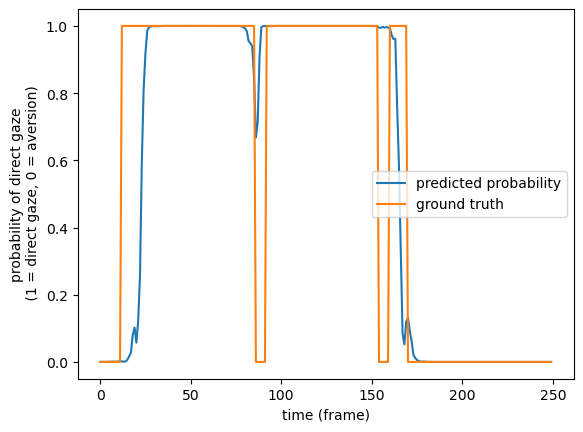

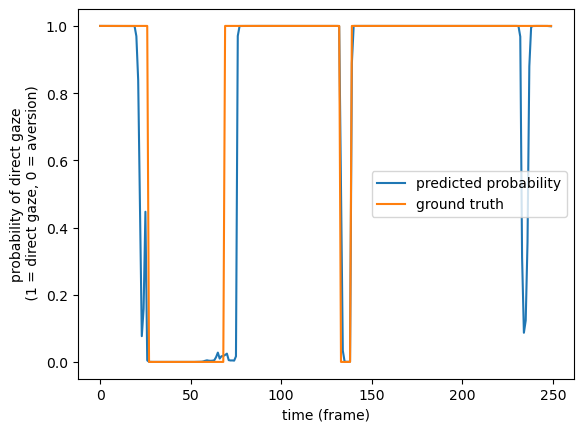

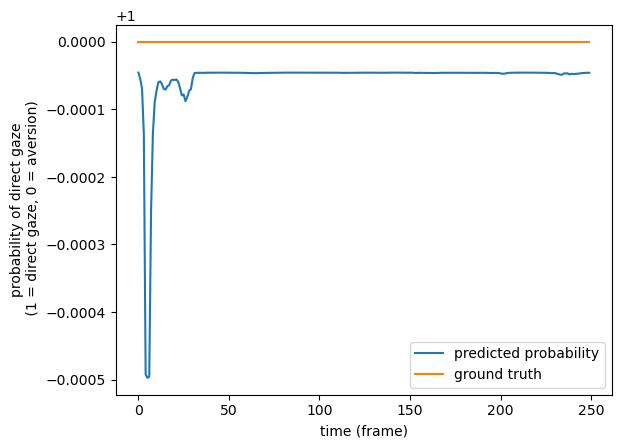

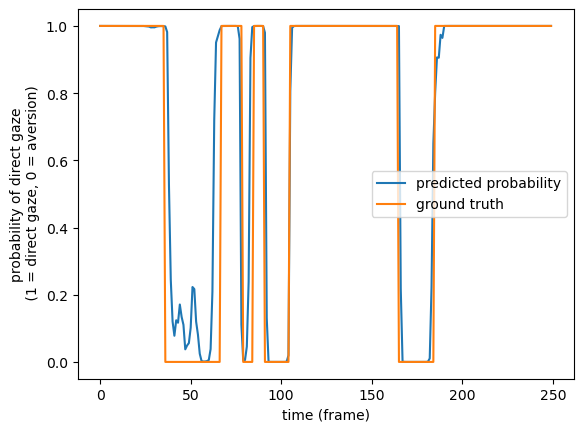

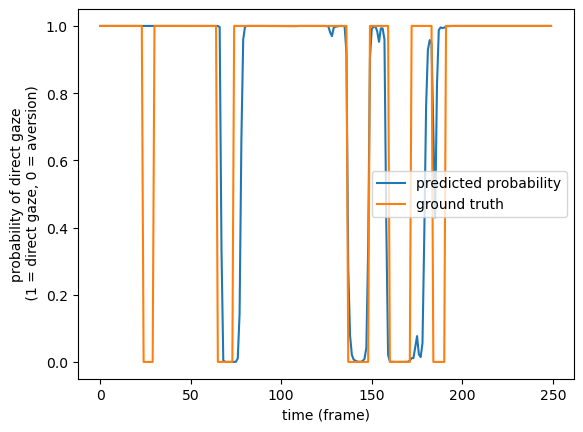

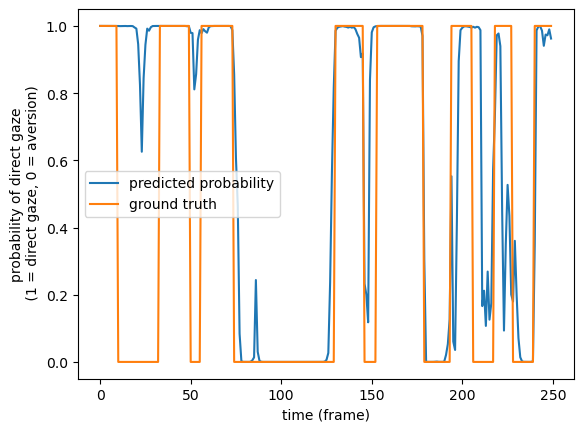

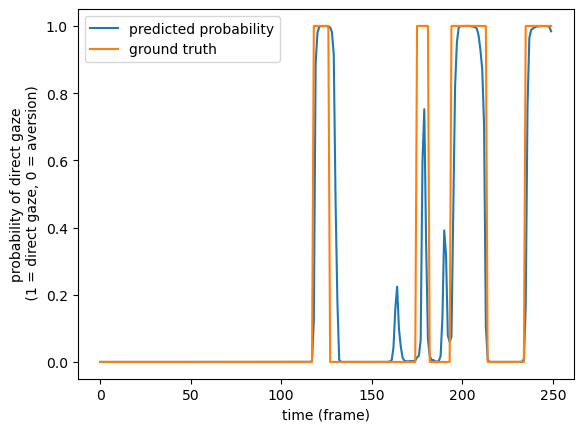

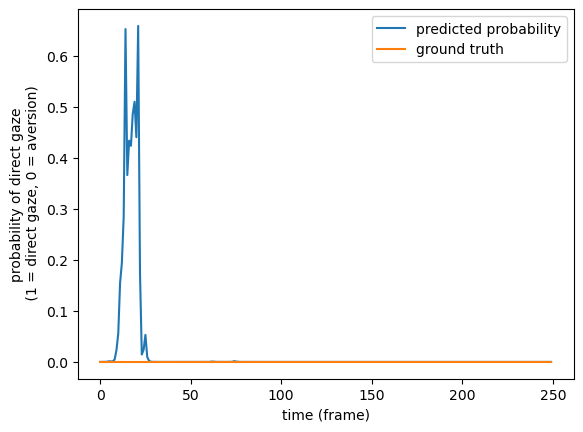

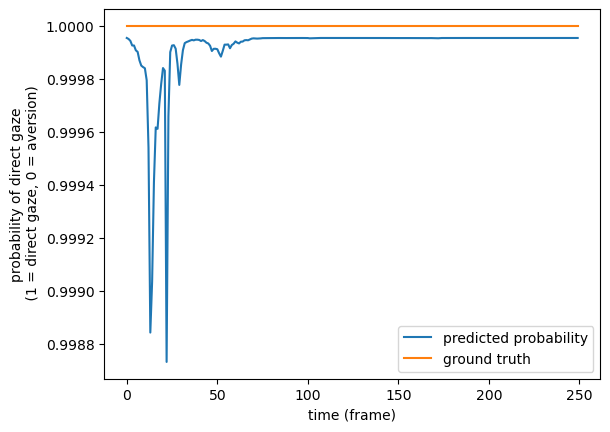

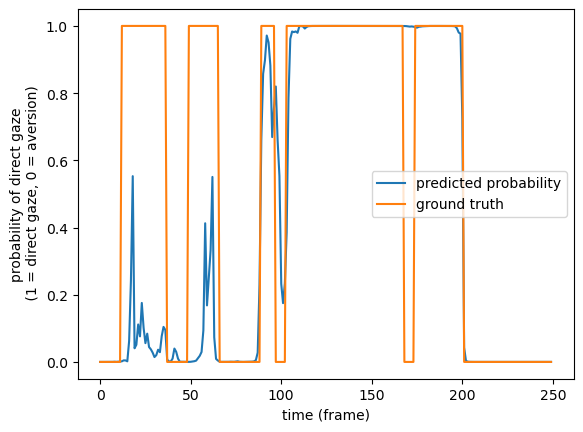

In [33]:
for i in range(0, 10):
    # audio_0, audio_1 = validation_dataset_with_gaze.get_audio(i)
    
    prob = all_raw_aversion_prediction[i][0]
    prob = softmax(prob, axis=1)
    plt.plot((prob[:, 1]), label="predicted probability")
    plt.plot(all_aversion_label[i][0], label="ground truth")
    plt.xlabel("time (frame)")
    plt.ylabel("probability of direct gaze\n (1 = direct gaze, 0 = aversion)")
    plt.legend()
    plt.show()

## Find discrete targets based on the heatmap.

In [38]:
def dispersion_filtering(x, y, dispersion_threshold = 6, duraiton_threshold=0.3):
    start = 0
    window = []
    fps = int(np.round(1/(x[1] - x[0])))
    duration_threshold_frames = np.ceil(duraiton_threshold * fps)
    
    def dispersion(arr):
        # input is a 2d array
        disp = np.max(arr[:, 0]) - np.min(arr[:, 0]) + np.max(arr[:, 1]) - np.min(arr[:, 1])
        return disp

    fixations = []
    fixations_intervals = []
    
    # while there are still points
    while int(start+duration_threshold_frames) < y.shape[0]:
        # initialize a window:
        window = list(range(int(start), int(start+duration_threshold_frames)))
        start = start + duration_threshold_frames
        disp = dispersion(y[window])
        while disp <= dispersion_threshold:
            disp = dispersion(y[window])
            if window[-1]+1 < y.shape[0]:
                window.append(window[-1]+1)
            start = start + 1
            if start >= y.shape[0]:
                break
        # if the current set of points never fit the duration criteria
        if len(window) <= duration_threshold_frames:
            start = start + 1
        # otherwise note it as fixations
        else:
            centroid = np.mean(y[window], axis=0)
            duration = (window[-1] - window[0]) / fps
            fixations.append([centroid[0], centroid[1], duration])
            fixations_intervals.append([window[0], window[-1]])
    fixations = np.array(fixations)
    return fixations, fixations_intervals

In [39]:
all_discrete_target_per_frame = [] # store the index of the discrete target attended to at each frame
all_discrete_target_positions = [] # store te position of all the discrete target at each frame 

from sklearn.mixture import GaussianMixture
skipped = []
for h in range(0, len(all_heatmaps_points)):
    ts = np.arange(0, all_heatmaps_points[h].shape[0]) / 25 # fps is 25
    heatmap_points = all_heatmaps_points[h]
    interlocutor_position = all_intelocutor_position[h]
    if interlocutor_position.shape[0] == 3:
        skipped.append(h)
        all_discrete_target_per_frame.append(np.zeros(all_aversion_label[h].shape))
        all_discrete_target_positions.append(np.zeros([all_aversion_label[h].shape[0], 2]))
        continue
    gaze_over_time = all_gaze_over_time[h]
    aversion_label = all_aversion_label[h][0]
    fixations, fixations_intervals = dispersion_filtering(ts, gaze_over_time, dispersion_threshold=6, duraiton_threshold=0.2)
    fixation_t = np.zeros(gaze_over_time.shape)
    for i in range(0, len(fixations_intervals)):
        for k in range(fixations_intervals[i][0], fixations_intervals[i][1]+1):
            fixation_t[k] = fixations[i, :2]
        if i == 0:
            for k in range(0, fixations_intervals[i][1]):
                fixation_t[k] = fixations[i, :2]
        else:
            for k in range(fixations_intervals[i-1][1], fixations_intervals[0][0]):
                fixation_t[k] = fixations[i, :2]
        if i == (len(fixations_intervals) - 1):
            for k in range(fixations_intervals[i][1], len(fixations_intervals)):
                fixation_t[k] = fixations[i, :2]
    # ========================================================
    # step 1 is to find all the gaze targets in the scene
    # ========================================================
    if fixation_t.shape[0] != aversion_label.shape[0]:
        continue
    non_interlocutor_aversion_targets = fixation_t[np.where(aversion_label == 0, True, False), :]
    # if there are non-interlocutor gaze targets, we cluster them then add them to "feasible_target_positions"
    if non_interlocutor_aversion_targets.shape[0] > 0:
        gmm = GaussianMixture(int(np.minimum(10, non_interlocutor_aversion_targets.shape[0]))).fit(non_interlocutor_aversion_targets, )
        mix = gmm.predict_proba(non_interlocutor_aversion_targets)
        # get cluster heads
        mixture_centers = gmm.means_
        # find the index of targets
        potential_target = np.argmax(mix, axis=1)
        # only keep the targets that are have at least 2 gaze towards it
        targets_tally = np.zeros(10)
        for i in range(0, potential_target.shape[0]):
            targets_tally[potential_target[i]] += 1
        feasible_targets = []
        # greedily remove the target too close to another target
        for i in range(0, targets_tally.shape[0]):
            if targets_tally[i] >= 2:
                feasible_targets.append(i)
        old_num = len(feasible_targets)
        # skipping the target removal since we don't care. We only use it for generating the video demo
        while False:
            removed = False
            is_kepted = np.ones(len(feasible_targets))

            for target_i in range(0, len(feasible_targets)):
                i_is_removed = False
                for target_j in range(0, len(feasible_targets)):
                    if target_i == target_j:
                        continue
                    position_i = mixture_centers[feasible_targets[target_i]]
                    position_j = mixture_centers[feasible_targets[target_j]]
                    if np.linalg.norm(position_i - position_j) < 7:
                        # find the one with less gaze towards it
                        if targets_tally[feasible_targets[target_i]] > targets_tally[feasible_targets[target_j]]:
                            is_kepted[target_j] = 0
                        else:
                            is_kepted[target_i] = 0
                        removed = True
                        break
            new_feasible_targets = []
            for i in range(0, len(feasible_targets)):
                if is_kepted[i] == 1:
                    new_feasible_targets.append(feasible_targets[i])
            feasible_targets = new_feasible_targets
            if not removed:
                break
        # print(old_num, len(feasible_targets))

        feasible_target_positions = mixture_centers[feasible_targets]
        # if there is aversion, then if DNN predicts P(aversion) > 0.5, our model's avershion would hopefully go there 
        feasible_target_positions_including_interlocutor = np.concatenate([np.expand_dims(interlocutor_position, axis=0), feasible_target_positions], axis=0)
        
    # if there are no non-interlocutor gaze targets, we just use the interlocutor position, so when our model predicts aversion, it will not shift its gaze
    else:
        # if there is no aversion, then if DNN predicts P(aversuib) > 0.5, our model's aversion has to still go away from the interlocutor
        # for this reason we add a fake target that is 20 degrees away from the interlocutor to the list of feasible targets
        feasible_target_positions_including_interlocutor = np.concatenate([np.expand_dims(interlocutor_position, axis=0), np.expand_dims(interlocutor_position + np.array([20, 0]), axis=0)], axis=0)
    # ========================================================
    # step 2 is to find the gaze target attended to at each frame
    # ========================================================
    # for discrete_target_per_frame:
    # 0 means no aversion which is also the index for interlocutor in feasible_target_positions_including_interlocutor
    # other numbers would point to other targets in feasible_target_positions_including_interlocutor
    if non_interlocutor_aversion_targets.shape[0] > 0 and feasible_target_positions.shape[0] > 0:
        discrete_target_per_frame = np.zeros(aversion_label.shape)
        discrete_target_per_frame[np.where(aversion_label == 1, True, False)] = 0
        cloest_look_at_point = (np.expand_dims(non_interlocutor_aversion_targets, axis=1) - np.expand_dims(feasible_target_positions, axis=0))
        cloest_look_at_point = np.sum(cloest_look_at_point * cloest_look_at_point, axis=2)
        # adding 1 because we are using feasible_target_positions_including_interlocutor instead of feasible_target_positions
        cloest_look_at_point = np.argmin(cloest_look_at_point, axis=1) + 1
        discrete_target_per_frame[np.where(aversion_label == 0, True, False)] = cloest_look_at_point
    else:
        discrete_target_per_frame = np.zeros(aversion_label.shape)
        
    # ========================================================
    all_discrete_target_per_frame.append(discrete_target_per_frame)
    all_discrete_target_positions.append(feasible_target_positions_including_interlocutor)

### Reiterate the inputs to the next step

In [40]:
all_heatmaps_img                # store a list of images that shows the heatmap
all_heatmaps_points             # store a list of [timestamp, windowsize, 2] (2 dims for x-angle + y-angle)
all_aversion_prediction         # just for true and false
all_aversion_label              # just for true and false
all_gaze_over_time              # store a list of [time_stamp, 2]
all_intelocutor_position        # store the position of intelocutor in [time_stamp, 2]
all_discrete_target_per_frame   # store the index of the discrete target attended to at each frame
all_discrete_target_positions   # store te position of all the discrete target at each frame

[array([[ 5.29873278, 11.12050455],
        [ 3.50094159,  2.50916572],
        [ 5.4543049 ,  6.66113771],
        [ 0.        ,  0.        ],
        [ 6.48215552,  8.05950154],
        [ 5.61263803,  4.73630106],
        [ 6.4725315 ,  1.88069046],
        [ 6.5599829 ,  7.09704704],
        [ 5.68199122,  8.61725916],
        [ 3.26287502,  5.37961775]]),
 array([[ 5.29873278, 11.12050455],
        [ 6.06364035,  3.58173121],
        [ 0.        ,  0.        ],
        [ 6.49119625,  7.63337698],
        [ 3.26287502,  5.37961775],
        [ 8.83169972,  3.45556246],
        [ 5.61263803,  4.73630106],
        [ 4.30714894,  3.67850732],
        [ 5.13634791,  6.54264822],
        [ 5.94730669,  6.96795577],
        [ 3.6340761 ,  4.54955298]]),
 array([[ 5.29873278, 11.12050455],
        [ 8.32399916,  4.29192783],
        [ 0.        ,  0.        ],
        [ 4.66862597,  4.65088702],
        [ 2.61894832, 14.07585649],
        [ 7.24703184,  8.02584293],
        [ 3.64184125,  6

In [41]:

# first step is to re-do the scene object
class AgentInfo_simplified:
    # image based variables
    def __init__(self, scene_data, discrete_targets, ts, wonder = False, only_windowed=True):
        self.wonder = wonder
        # get camera position
        try:
            self.camera_pos = np.array([0, 0, 1])
        except:
            self.camera_pos = np.array([0, 0, 1])
        # the position of the speaker, in world coordinate (constant in this version)
        self.self_position_world = np.array([0, 0, 0])
        self.speaker_frame_pos = np.array([0, 0, 0])
        # get info used to compute transformation matrix from world coordinate to face coordinate
        self.speaker_face_direction_local = np.array([0, 0, 100])
        v_ref_world = np.array([0, 0, 100])
        v_ref_local = np.array([0, 0, 100])
        self.local_to_world = self.rotation_matrix_from_vectors(v_ref_local, v_ref_world - self.self_position_world)
        self.world_to_local = np.linalg.inv(self.local_to_world)
        # get info regarding other items in the scene
        temp_object_type, temp_object_pos, temp_object_interest = scene_data["object_type"], scene_data["object_pos"], scene_data["object_interestingness"]
        temp_scene_object_ids = list(temp_object_pos.keys())
        # name of the passive objects of the scene
        self.object_pos = []
        self.object_interest = []
        self.object_id = []
        for i in range(0, len(temp_scene_object_ids)):
            if only_windowed:
                self.object_interest.append([])
            else:
                self.object_interest.append([0, 1])
            self.object_pos.append(temp_object_pos[temp_scene_object_ids[i]])
            self.object_id.append(temp_scene_object_ids[i])
        if only_windowed:
            for i in range(0, len(discrete_targets)):
                for item_id in range(0, len(self.object_interest)):
                    if item_id in discrete_targets[i]:
                        if item_id == 0:
                            self.object_interest[item_id].append([ts[i], 1])
                        else:
                            self.object_interest[item_id].append([ts[i], 0.5])
                    else:
                        self.object_interest[item_id].append([ts[i], 0])
        self.object_pos = np.array(self.object_pos)
        for i in range(0, len(self.object_interest)):
            self.object_interest[i] = np.array(self.object_interest[i])
        self.active_object_id = 0
        self.other_speaker_id = 0
        # get the id of the other active objec in the scene
        for i in range(0, len(temp_scene_object_ids)):
            if temp_object_type[temp_scene_object_ids[i]] == 5:
                self.other_speaker_id = i
                self.active_object_id = i
        self.scene_data = scene_data
    def rotation_matrix_from_vectors(self, vec1, vec2):
        """ Find the rotation matrix that aligns vec1 to vec2
        :param vec1: A 3d "source" vector
        :param vec2: A 3d "destination" vector
        :return mat: A transform matrix (3x3) which when applied to vec1z, aligns it with vec2.
        """
        a, b = (vec1 / np.linalg.norm(vec1)).reshape(3), (vec2 / np.linalg.norm(vec2)).reshape(3)
        v = np.cross(a, b)
        c = np.dot(a, b)
        if c == 1:
            return np.eye(3)
        elif c == -1:
            return -np.eye(3)

        s = np.linalg.norm(v)
        kmat = np.array([[0, -v[2], v[1]], [v[2], 0, -v[0]], [-v[1], v[0], 0]])
        rotation_matrix = np.eye(3) + kmat + kmat.dot(kmat) * ((1 - c) / (s ** 2))
        return rotation_matrix
    def get_wondering_points(self, neutral_gaze_spot_local=np.array([0, 0, 100]), coordinate_space="local"):
        """
        get all the looking positions in local frame
        :param neutral_gaze_spot_local: the default gaze position
        :return: a [6, 3] array of all the positions to wonder
        """
        wondering_angles = [[0, -10], [0, 8], [-5, -5], [5, -5], [5, 5], [-5, 5]]
        # wondering_angles = [[-10, -10], [10, -10], [10, 10], [-10, 10]]
        # print(wondering_angles)
        out_positions = []
        out_angles = []
        neutral_gaze_spot_local = self.get_active_object_position()
        neutral_gaze_angle = rotation_angles_frome_positions(neutral_gaze_spot_local)
        for angle in wondering_angles:
            new_angle = np.zeros((1, 2))
            new_angle[0, 0] = neutral_gaze_angle[0] + angle[0]
            new_angle[0, 1] = neutral_gaze_angle[1] + angle[1]
            out_angles.append(new_angle)
        out_angles = np.concatenate(out_angles, axis=0)
        out_positions = directions_from_rotation_angles(out_angles, np.linalg.norm(neutral_gaze_spot_local))
        if coordinate_space == "local":
            return out_positions
        else:
            out = np.zeros(out_positions.shape)
            for i in range(0, out.shape[0]):
                out[i] = self.transform_local_to_world(out_positions[i])
            return out
    def transform_world_to_local(self, pos_world):
        p = pos_world - self.self_position_world
        return self.world_to_local @ p
    def transform_local_to_world(self, pos_local):
        p = self.local_to_world @ pos_local + self.self_position_world
        return p
    def get_object_positions(self, id=-1, coordinate_space="local"):
        if id < 0:
            if coordinate_space == "global":
                return self.object_pos
            elif coordinate_space == "local":
                out = np.zeros(self.object_pos.shape)
                for i in range(0, self.object_pos.shape[0]):
                    out[i] = self.transform_world_to_local(self.object_pos[i])
                return out
        elif id >= 0:
            if coordinate_space == "global":
                return self.object_pos[id]
            elif coordinate_space == "local":
                out = self.transform_world_to_local(self.object_pos[id])
                return out
    def get_active_object_position(self, coordinate_space="local"):
        id = self.active_object_id
        return self.get_object_positions(id, coordinate_space=coordinate_space)
    def get_all_positions(self, coordinate_space="local"):
        objs = self.get_object_positions(coordinate_space=coordinate_space)
        active_objs = self.get_active_object_position()
        wp = self.get_wondering_points(coordinate_space=coordinate_space, neutral_gaze_spot_local=active_objs)
        if self.wonder:
            possss = np.concatenate([objs, wp], axis=0)
        else:
            possss = np.concatenate([objs], axis=0)
        return possss
    def get_interest(self, object_id, t):
        interest_arr = self.object_interest[object_id]
        # print(interest_arr)
        if interest_arr.shape[0] == 1:
            return interest_arr[0][1]
        else:
            for i in range(1, interest_arr.shape[0]):
                if interest_arr[i][0] > t:
                    return interest_arr[i-1][1]
        return interest_arr[-1][1]
    def get_camera_pos(self, coordinate_space="local"):
        if coordinate_space == "local":
            return self.transform_world_to_local(self.camera_pos)
        else:
            return self.camera_pos
class Neural_input_Saliency_dynamic_scene(Base_Static_Saliency_List):
    def __init__(self, scene_info: AgentInfo_final, ts, tag_duration, dt=1/24):
        self.scene_info: AgentInfo_final = scene_info
        self._number_of_objects = scene_info.get_all_positions().shape[0]
        self._dt = dt # 100 hz
        self._numb_of_frames = ts.shape[0] # total number of frames
        self.evaluated = False
        self.map = np.zeros((int(self._numb_of_frames), self._number_of_objects))
        self.map_interp = None
        # determine the gaze target over time. 
        self.gaze_target_over_time = []
        self.tag_duration = tag_duration
        self.get_active_object_from_tags()
    def get_index(self, target_name):
        for i in range(0, len(self.scene_info.object_id)):
            if self.scene_info.object_id[i] == target_name:
                return i
        print("Cannot find tagged object in the scene, check the tags in the dialog file.")
        return -1
    def get_active_object_from_tags(self):
        try:
            targets = self.tag_duration["target"]
        except:
            targets = []
        if len(targets) == 0:
            self.gaze_target_over_time = [[0, self.scene_info.other_speaker_id]]
        else:
            self.gaze_target_over_time = [[0, self.scene_info.other_speaker_id]]
            starting_idx = 0
            if targets[0][1] == 0:
                idx = self.get_index(targets[0][0])
                self.gaze_target_over_time = [[0, idx]]
                self.gaze_target_over_time.append([targets[0][2], self.scene_info.other_speaker_id])
                # if the first element is not the other speaker then we initialize the gaze_target_over_time array differently, so we
                # skip the index by one 
                starting_idx = 1
            for i in range(starting_idx, len(targets)):
                idx = self.get_index(targets[i][0])
                self.gaze_target_over_time.append([targets[i][1], idx])
                self.gaze_target_over_time.append([targets[i][2], self.scene_info.other_speaker_id])       
    def get_object_positions(self):
        return self.scene_info.get_all_positions()
    def evaluate_all(self):
        if self.evaluated:
            return self.map
        else:
            self.compute_salience()
            x = np.arange(0, self._numb_of_frames) * self._dt
            self.map_interp = interp1d(x, self.map, axis=0, fill_value="extrapolate", bounds_error=False)
            self.evaluated = True
            return self.map
    def evaluate(self, t):
        if self.evaluated:
            return self.map_interp(t)
        else:
            self.compute_salience()
            x = np.arange(0, self._numb_of_frames) * self._dt
            self.map_interp = interp1d(x, self.map, axis=0, fill_value="extrapolate")
            self.evaluated = True
            return self.map_interp(t)
    def compute_salience(self, aversion_prob_time, aversion_prob_val, interval=True):
        # continue setting salience for all objects
        inteppp = interp1d(aversion_prob_time, aversion_prob_val, bounds_error=False, fill_value="extrapolate")
        for j in range(0, self._numb_of_frames):
            for i in range(0, self._number_of_objects):
                if i < self.scene_info.get_object_positions(coordinate_space="global").shape[0]:
                    self.map[j, i] = self.scene_info.get_interest(i, j * self._dt)
                else:
                    if inteppp(float(j) * self._dt) < 0.3:
                        self.map[j, i] = 0
                    else:
                        self.map[j, i] = 0.15


### Now that we have aversion labels, and aversion probability, the next step is to use gaze plannner to generate gaze

In [42]:
i = 240 
fps = 25
# while i in skipped:
#     i = i + 1
accurate_pred = 0
total_pred = 0
accurate_aversion_position = 0
total_aversion = 0
aversion_position_accuracy_during_aversion = 0
for clip_i in range(0, len(all_aversion_prediction)):
# for clip_i in range(0, 20):
    aversion_prediction = all_aversion_prediction[clip_i]
    aversion_label = all_aversion_label[clip_i]  
    ts = np.arange(0, 250) / 25.0
    gaze_over_time = all_gaze_over_time[clip_i]
    discrete_target_per_frame = all_discrete_target_per_frame[clip_i]
    discrete_target_positions = all_discrete_target_positions[clip_i]
    # get the per-frame heatmap information
    heatmap_input = all_heatmaps_points[clip_i]
    heatmap_discrete_input = []
    interlocutor_position = all_intelocutor_position[clip_i]
    for i in range(0, heatmap_input.shape[0]):
        # find the closest discrete target position
        closest_discrete_target = np.argmin(np.sum(np.square(np.expand_dims(heatmap_input[i], axis=0) - np.expand_dims(discrete_target_positions, axis=1)), axis=2), axis=0)
        # remove duplicates in closest_discrete_target
        discrete_targets = list(set(closest_discrete_target.tolist()))
        heatmap_discrete_input.append(discrete_targets)
    object_type = [5]
    object_interest = [[[0, 1]]]
    object_names = ['obj_{0}']
    for i in range(1, discrete_target_positions.shape[0]):
        object_type.append(2)
        object_interest.append([[0, 0.5]])
        object_names.append('obj_{i}')
    object_type_dict = {}
    object_interest_dict = {}
    object_pos_dict = {}
    object_positions = directions_from_rotation_angles(discrete_target_positions, 100)

    for i in range(0, len(object_names)):
        object_type_dict[object_names[i]] = object_type[i]
        object_interest_dict[object_names[i]] = object_interest[i]
        object_pos_dict[object_names[i]] = object_positions[i]

    scene_data = {"object_type": object_type_dict,
                "object_interestingness": object_interest_dict,
                "object_pos": object_pos_dict}
    agentScene = AgentInfo_simplified(scene_data, heatmap_discrete_input, ts)
    activity=np.ones([250, ])
    audio_0, audio_1 = validation_dataset_with_gaze.get_audio(i)
    intensity = np.sqrt(np.sum(np.square(audio_0[:, :13]), axis=1))
    beats = get_beats(intensity)
    ts = np.arange(0, 250)/25
    onscreen_audio_feature_path = os.path.join(*[dataset_location, "audio", "clip_{}_speaker_{}.npy".format(i, 0)])

    aversion_prediction_binary = aversion_prediction[0, :]
    aversion_prediction_binary = runEuro(ts, aversion_prediction_binary)[:, 0]
    aversion_prediction_binary = np.where(aversion_prediction_binary > 0.5, 1, 0)
    aversion_saliency_0 = Neural_input_Saliency_dynamic_scene(agentScene, ts, {}, 1.0/fps)
    aversion_saliency_0.compute_salience(ts, aversion_prediction_binary)
    planner0 = Responsive_planner_Differnet_Targets([aversion_saliency_0], agentScene, aversion_prediction_binary, aversion_prediction_binary, activity, beats[:, 0], min_saccade_time_consecutive=4)
    output_times_0, output_targets_0 = planner0.compute()
    gaze_target_pos = np.zeros([250, 2])
    counter = 0
    for j in range(0, 250):
        if counter < len(output_times_0) - 1 and ts[j] >= output_times_0[counter]:
            counter += 1
        gaze_target_pos[j] = rotation_angles_frome_positions(agentScene.get_object_positions(output_targets_0[counter], coordinate_space="local"))
    for j in range(0, 250):
        if aversion_label[0, j] == aversion_prediction[0, j, 0]:
            accurate_pred += 1
            if aversion_label[0, j] == 1:
                accurate_aversion_position += 1
        if aversion_label[0, j] == 0 and np.linalg.norm(gaze_target_pos[j] - gaze_over_time[j]) < 10:
            accurate_aversion_position += 1
            aversion_position_accuracy_during_aversion += 1
        # 0 is aversion
        if aversion_label[0, j] == 0:
            total_aversion += 1     
        
    total_pred += 250
    # plt.scatter(gaze_over_time[:, 0], gaze_over_time[:, 1] , s = 5, label="gaze detected")
    # plt.scatter(interlocutor_position[0], interlocutor_position[1], s = 100, label="interlocutor positions")
    # plt.scatter(discrete_target_positions[:, 0], discrete_target_positions[:, 1], color="r", label="discrete gaze targets detected")
    # plt.legend()
    # plt.show()

AttributeError: 'Runtime_parsing_Aversion_SelfTape111' object has no attribute 'get_audio'

In [ ]:
print("overall accuracy = ", accurate_pred/total_pred)
print("aversion position acuracy overall = ", accurate_aversion_position/total_pred)
print("aversion position acuracy during aversion = ", aversion_position_accuracy_during_aversion/total_aversion)
print("ratio of aversion is = ", total_aversion/total_pred)

ZeroDivisionError: division by zero

In [ ]:
direct_gaze = 0
aversion = 0
for i in range(0, len(all_aversion_label)):
    labels = all_aversion_label[i][0]
    for l in range(0, labels.shape[0]):
        if labels[l] == 0:
            aversion += 1
        else:
            direct_gaze += 1
print("ratio of aversion: ", aversion/(aversion+direct_gaze))
print("ratio of direct gaze: ", direct_gaze/(aversion+direct_gaze))


ratio of aversion:  0.5225060240963856
ratio of direct gaze:  0.4774939759036145


# Look At the Aversion/Direct gaze Labeling accuracy of the ground truth

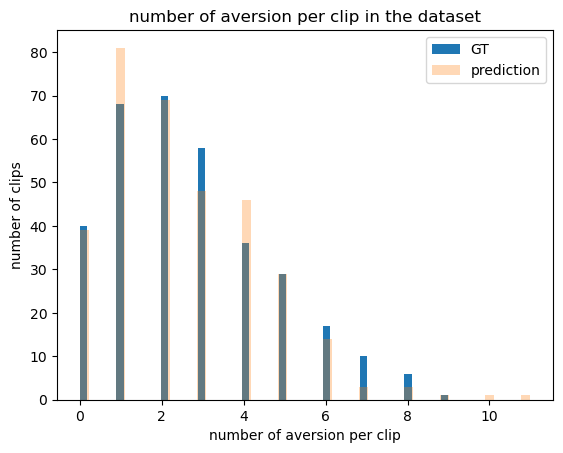

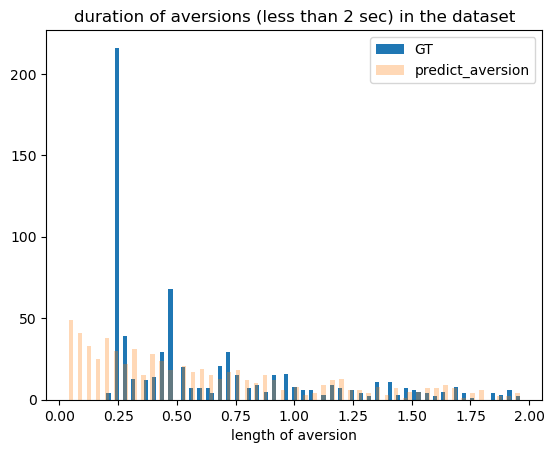

In [54]:
from Signal_processing_utils import get_activity_interval
all_aversion_label_intervals = []
all_aversion_prediction_intervals = []
for i in range(0, len(all_aversion_prediction)):
    aversion_prediction = 1-all_aversion_prediction[i][0, :, 0]
    aversion_label = 1-all_aversion_label[i][0]
    ts = np.arange(0, 250)/25.0
    aversion_label_activity_interval = get_activity_interval(aversion_label, ts)
    aversion_prediction_activity_interval = get_activity_interval(aversion_prediction, ts)
    all_aversion_label_intervals.append(aversion_label_activity_interval)
    all_aversion_prediction_intervals.append(aversion_prediction_activity_interval)
all_num_of_aversion_GT = []
all_num_of_aversion_prediction = []
all_window_length_of_aversion_GT = []
all_window_length_of_aversion_prediction = []
for i in range(0, len(all_aversion_label_intervals)):
    all_num_of_aversion_GT.append(len(all_aversion_label_intervals[i]))
    all_num_of_aversion_prediction.append(len(all_aversion_prediction_intervals[i]))
    for j in range(0, len(all_aversion_label_intervals[i])):
        all_window_length_of_aversion_GT.append(all_aversion_label_intervals[i][j][1] - all_aversion_label_intervals[i][j][0])
    for j in range(0, len(all_aversion_prediction_intervals[i])):
        all_window_length_of_aversion_prediction.append(all_aversion_prediction_intervals[i][j][1] - all_aversion_prediction_intervals[i][j][0])
# plt.hist(all_num_of_aversion_prediction, bins=50, label="prediction")
plt.hist(all_num_of_aversion_GT, bins=50, label="GT")
# plt.legend()
# plt.show()
plt.hist(all_num_of_aversion_prediction, bins=50, label="prediction", alpha = 0.3)
plt.xlabel("number of aversion per clip")
plt.ylabel("number of clips")
plt.title("number of aversion per clip in the dataset")
plt.legend()
plt.show()
all_window_length_of_aversion_GT = np.array(all_window_length_of_aversion_GT)[np.where(np.array(all_window_length_of_aversion_GT), True, False)]
all_window_length_of_aversion_GT = all_window_length_of_aversion_GT[np.where(all_window_length_of_aversion_GT >= 0.2, True, False)]
plt.hist(all_window_length_of_aversion_GT, bins = 100, label="GT")
plt.xlabel("length of aversion")
all_window_length_of_aversion_prediction = np.array(all_window_length_of_aversion_prediction)[np.where(np.array(all_window_length_of_aversion_prediction) < 2, True, False)]
plt.hist(all_window_length_of_aversion_prediction, bins = 100, label="predict_aversion", alpha = 0.3)
plt.title("duration of aversions (less than 2 sec) in the dataset")
plt.legend()
plt.show()


# Look at videos with too many aversions:

In [43]:
from scipy.special import softmax
max_aversion_i = np.argmax(all_num_of_aversion_prediction)


for i in range(0, len(all_num_of_aversion_prediction)):
    if all_num_of_aversion_prediction[i] >= 10:

        prob = all_raw_aversion_prediction[i][0]
        prob = softmax(prob, axis=1)
        plt.plot((prob[:, 1]), label="predicted probability")
        plt.plot(all_aversion_label[i][0], label="ground truth")
        plt.xlabel("time (frame)")
        plt.ylabel("probability of direct gaze\n (1 = direct gaze, 0 = aversion)")
        plt.legend()
        plt.show()

NameError: name 'all_num_of_aversion_prediction' is not defined

# Evaluate Interval accraucy with Levenstein distance

In [44]:
from Signal_processing_utils import get_activity_interval
def get_string_from_intervals(interval, end_t):
    out_string = ""
    if interval[0][0] == 0:
        # if the first inter
        out_string += "1"
    else:
        out_string += "0"
    for i in range(1, len(interval)):            
        if out_string[-1] == "0":
            out_string += "1"
        else:
            out_string += "0"
            out_string += "1"
        if interval[i][1] == end_t:
            out_string += "0"
    return out_string
        


Get all the intervals as strings

In [45]:
all_aversion_label_intervals_string = []
all_aversion_prediction_intervals_string = []
for i in range(0, len(all_aversion_prediction)):
    aversion_prediction = all_aversion_prediction[i][0, :, 0]
    aversion_label = all_aversion_label[i][0]
    ts = np.arange(0, 250)/25.0
    aversion_label_activity_interval = get_activity_interval(aversion_label, ts)
    aversion_prediction_activity_interval = get_activity_interval(aversion_prediction, ts)
    if len(aversion_prediction_activity_interval) == 0 or len(aversion_label_activity_interval) == 0:
        continue
    aversion_label_string = get_string_from_intervals(aversion_label_activity_interval, ts[-1])
    aversion_prediction_string = get_string_from_intervals(aversion_prediction_activity_interval, ts[-1])
    all_aversion_label_intervals_string.append(aversion_label_string)
    all_aversion_prediction_intervals_string.append(aversion_prediction_string)


Compute Levestein distance

In [46]:
def compute_levenshtein_distance_with_features(string1, string2):
    len1 = len(string1)
    len2 = len(string2)

    # Create a matrix to store the distances and operations
    dp = [[0 for _ in range(len2 + 1)] for _ in range(len1 + 1)]

    # Initialize the first row and column
    for i in range(len1 + 1):
        dp[i][0] = i

    for j in range(len2 + 1):
        dp[0][j] = j

    # Fill in the matrix
    for i in range(1, len1 + 1):
        for j in range(1, len2 + 1):
            cost = 0 if string1[i - 1] == string2[j - 1] else 1
            dp[i][j] = min(
                dp[i - 1][j] + 1,  # Deletion
                dp[i][j - 1] + 1,  # Insertion
                dp[i - 1][j - 1] + cost,  # Substitution
            )

    # Trace back to find the operations
    i, j = len1, len2
    deletion_count, insertion_count, substitution_count = 0, 0, 0

    while i > 0 or j > 0:
        if i > 0 and dp[i][j] == dp[i - 1][j] + 1:
            deletion_count += 1
            i -= 1
        elif j > 0 and dp[i][j] == dp[i][j - 1] + 1:
            insertion_count += 1
            j -= 1
        else:
            if dp[i][j] == dp[i - 1][j - 1] + 1:
                substitution_count += 1
            i -= 1
            j -= 1

    return {
        'total_distance': dp[len1][len2],
        'deletion_count': deletion_count,
        'insertion_count': insertion_count,
        'substitution_count': substitution_count
    }

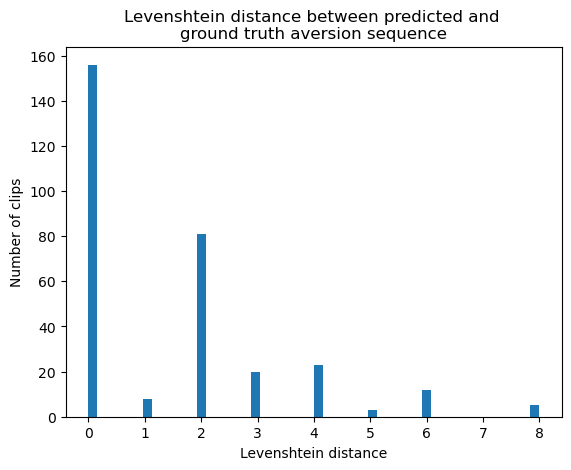

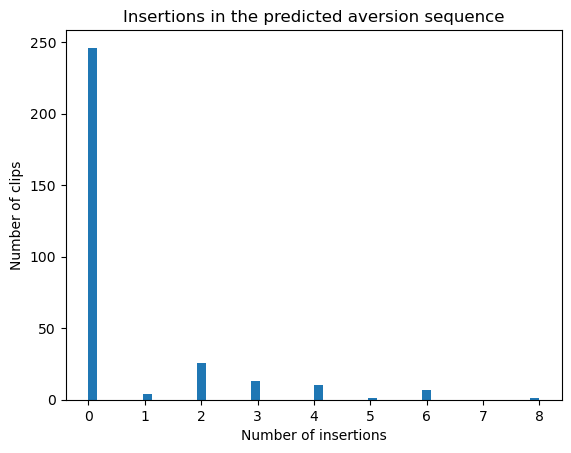

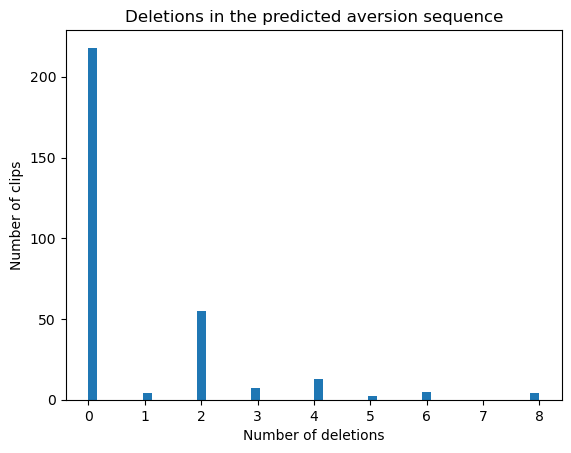

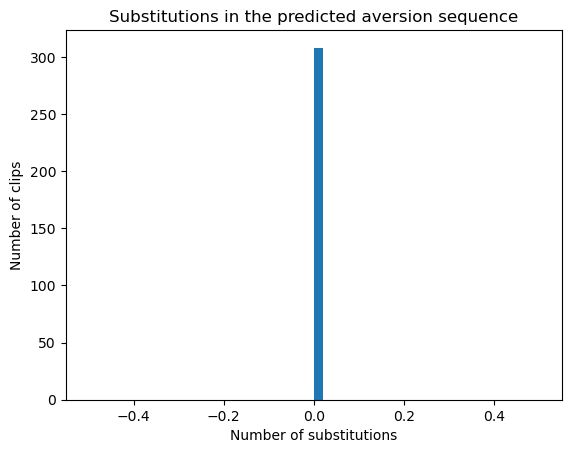

In [47]:
all_levenshtein_distance = []
all_levenshtein_distance_insertions = []
all_levenshtein_distance_deletions = []
all_levenshtein_distance_substitutions = []

for i in range(0, len(all_aversion_label_intervals_string)):
    all_features = compute_levenshtein_distance_with_features(all_aversion_label_intervals_string[i], all_aversion_prediction_intervals_string[i])
    all_levenshtein_distance.append(all_features["total_distance"])
    all_levenshtein_distance_insertions.append(all_features["insertion_count"])
    all_levenshtein_distance_deletions.append(all_features["deletion_count"])
    all_levenshtein_distance_substitutions.append(all_features["substitution_count"])




plt.hist(all_levenshtein_distance, bins=50)
plt.title("Levenshtein distance between predicted and \nground truth aversion sequence")
plt.xlabel("Levenshtein distance")
plt.ylabel("Number of clips")
plt.show()

plt.hist(all_levenshtein_distance_insertions, bins=50)
plt.title("Insertions in the predicted aversion sequence")
plt.xlabel("Number of insertions")
plt.ylabel("Number of clips")
plt.show()

plt.hist(all_levenshtein_distance_deletions, bins=50)
plt.title("Deletions in the predicted aversion sequence")
plt.xlabel("Number of deletions")
plt.ylabel("Number of clips")
plt.show()

plt.hist(all_levenshtein_distance_substitutions, bins=50)
plt.title("Substitutions in the predicted aversion sequence")
plt.xlabel("Number of substitutions")
plt.ylabel("Number of clips")
plt.show()



In [33]:
print(np.sum(all_levenshtein_distance))
print(np.sum(all_levenshtein_distance_insertions))
print(np.sum(all_levenshtein_distance_deletions))
print(np.sum(all_levenshtein_distance_substitutions))

2453
2452
1
0


# Evaluate Prediction Accuracy of Onset/Offset

In [34]:
def find_closest_onset_time(interval_list_1, interval_list_2):
    # this will be a list of deltas closest
    closest_onset_times_list = []
    for i in range(0, len(interval_list_1)):
        interval_i = interval_list_1[i]

        minimal_distance_ji = 100000000
        minimal_distance_index_ji = -1
        for j in range(0, len(interval_list_2)):
            if abs(interval_list_2[j][0] - interval_i[0]) < abs(minimal_distance_ji):
                minimal_distance_index_ji = j
                minimal_distance_ji = interval_list_2[j][0] - interval_i[0]
        # here negative means late, 
        if minimal_distance_index_ji != -1:
            closest_onset_times_list.append(minimal_distance_ji)
    return closest_onset_times_list

def find_closest_end_time(interval_list_1, interval_list_2):
    # this will be a list of deltas closest
    closest_end_times_list = []
    for i in range(0, len(interval_list_1)):
        interval_i = interval_list_1[i]
        minimal_distance_ji = 100000000
        minimal_distance_index_ji = -1
        for j in range(0, len(interval_list_2)):
            if abs(interval_list_2[j][1] - interval_i[1]) < abs(minimal_distance_ji):
                minimal_distance_index_ji = j
                minimal_distance_ji = interval_list_2[j][1] - interval_i[1]
        # here negative means late, 
        if minimal_distance_index_ji != -1:
            closest_end_times_list.append(minimal_distance_ji)
    return closest_end_times_list

## Looking at one example

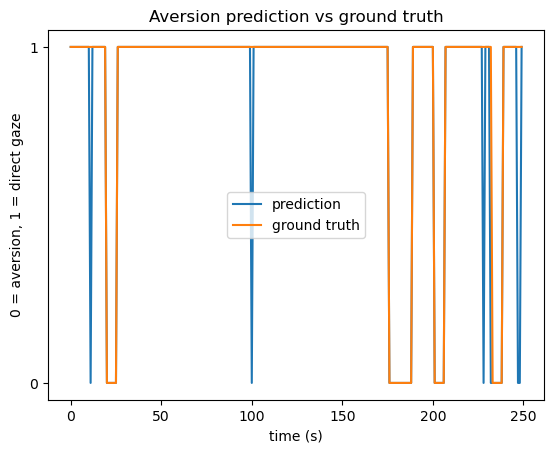

In [35]:
i = 0
aversion_prediction = all_aversion_prediction[i][0, :, 0]
aversion_label = all_aversion_label[i][0]
plt.plot(aversion_prediction, label="prediction")
plt.plot(aversion_label, label="ground truth")
plt.title("Aversion prediction vs ground truth")
plt.legend()
plt.xlabel("time (s)")
plt.ylabel("0 = aversion, 1 = direct gaze")
plt.yticks([0, 1])
plt.show()

## Consider all events of aversion/Direct gaze

In [36]:
all_aversion_onset_delta = []
all_aversion_end_delta = []

for i in range(0, len(all_aversion_prediction)):
    aversion_prediction = -all_aversion_prediction[i][0, :, 0] + 1
    aversion_label = -all_aversion_label[i][0] + 1
    ts = np.arange(0, 250)/25.0
    aversion_label_activity_interval = get_activity_interval(aversion_label, ts)
    aversion_prediction_activity_interval = get_activity_interval(aversion_prediction, ts)
    onset_time_delta_list = find_closest_onset_time(aversion_prediction_activity_interval, aversion_label_activity_interval)
    all_aversion_onset_delta += onset_time_delta_list
    end_time_delta_list = find_closest_end_time(aversion_prediction_activity_interval, aversion_label_activity_interval)
    all_aversion_end_delta += end_time_delta_list

the mean error with respect to ground truth is for start of direct gaze is:  0.4444423529411765
the mean error with respect to ground truth is for start of aversion is:  -0.3322164705882353


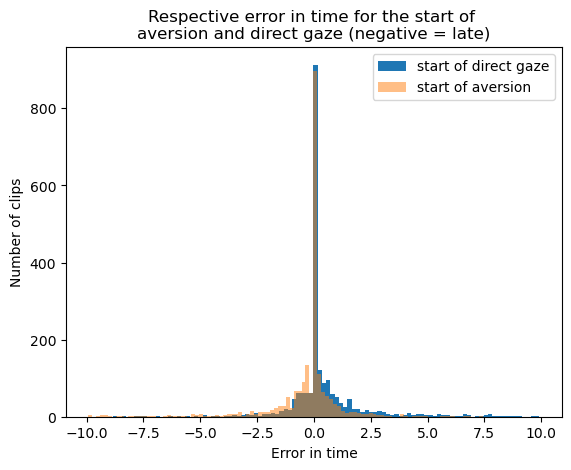

Text(0.5, 1.0, 'Respective error in time for the start of \naversion and direct gaze (negative = late)')

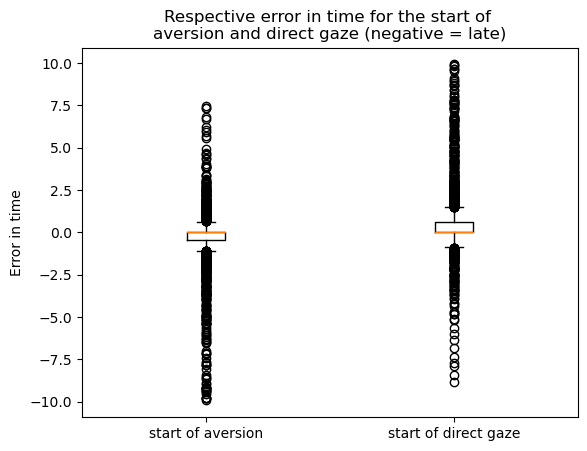

In [37]:
print("the mean error with respect to ground truth is for start of direct gaze is: ", np.mean(all_aversion_end_delta))
print("the mean error with respect to ground truth is for start of aversion is: ", np.mean(all_aversion_onset_delta))
plt.hist(all_aversion_end_delta, bins=100, label="start of direct gaze")
plt.hist(all_aversion_onset_delta, bins=100, label="start of aversion", alpha=0.5)
plt.xlabel("Error in time")
plt.ylabel("Number of clips")
plt.legend()
plt.title("Respective error in time for the start of \naversion and direct gaze (negative = late)")
plt.show()

# show box plot, clip numbers at 5
plt.boxplot([all_aversion_onset_delta, all_aversion_end_delta], labels=["start of aversion", "start of direct gaze"], autorange=True)
plt.ylabel("Error in time")
plt.title("Respective error in time for the start of \naversion and direct gaze (negative = late)")

## Consider only events of aversion/Direct gaze that overlaps with ground truth

In [38]:
def filter_non_overlap_intervals(gt_intervals, predicted_intervals):
    overlapped_predicted_intervals = []
    for i in range(0, len(predicted_intervals)):
        predicted_interval = predicted_intervals[i]
        for j in range(0, len(gt_intervals)):
            gt_interval = gt_intervals[j]
            if predicted_interval[0] <= gt_interval[1] and predicted_interval[1] >= gt_interval[0]:
                overlapped_predicted_intervals.append(predicted_interval)
                break
    return overlapped_predicted_intervals

In [39]:
all_aversion_onset_delta = []
all_aversion_end_delta = []

for i in range(0, len(all_aversion_prediction)):
    aversion_prediction = 1-all_aversion_prediction[i][0, :, 0]
    aversion_label = 1-all_aversion_label[i][0]
    ts = np.arange(0, 250)/25.0
    aversion_label_activity_interval = get_activity_interval(aversion_label, ts)
    aversion_prediction_activity_interval = get_activity_interval(aversion_prediction, ts)
    filtered_aversion_prediction_activity_interval = filter_non_overlap_intervals(aversion_label_activity_interval, aversion_prediction_activity_interval)
    onset_time_delta_list = find_closest_onset_time(filtered_aversion_prediction_activity_interval, aversion_label_activity_interval)
    all_aversion_onset_delta += onset_time_delta_list
    end_time_delta_list = find_closest_end_time(filtered_aversion_prediction_activity_interval, aversion_label_activity_interval)
    all_aversion_end_delta += end_time_delta_list


the mean error with respect to ground truth is for start of direct gaze is:  0.9035533760844965
the mean error with respect to ground truth is for start of aversion is:  -0.3853338362881931


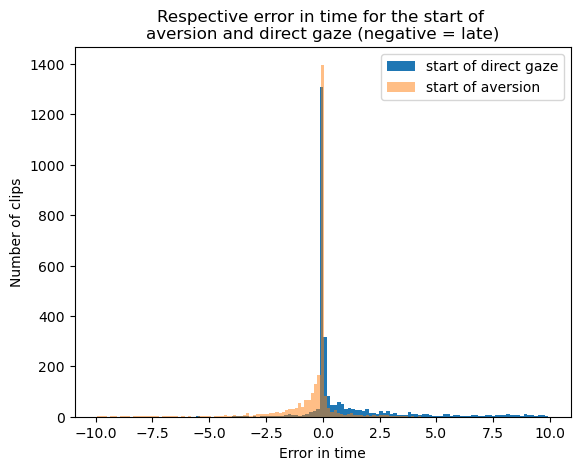

Text(0.5, 1.0, 'Respective error in time for the start of \naversion and direct gaze (negative = late)')

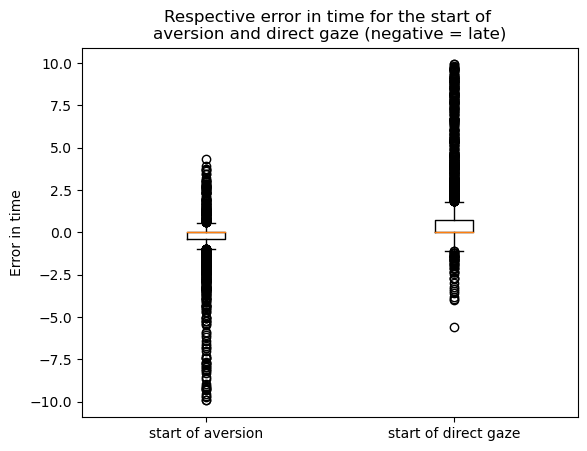

In [140]:
print("the mean error with respect to ground truth is for start of direct gaze is: ", np.mean(all_aversion_end_delta))
print("the mean error with respect to ground truth is for start of aversion is: ", np.mean(all_aversion_onset_delta))
plt.hist(all_aversion_end_delta, bins=100, label="start of direct gaze")
plt.hist(all_aversion_onset_delta, bins=100, label="start of aversion", alpha=0.5)
plt.xlabel("Error in time")
plt.ylabel("Number of clips")
plt.legend()
plt.title("Respective error in time for the start of \naversion and direct gaze (negative = late)")
plt.show()

# show box plot, clip numbers at 5
plt.boxplot([all_aversion_onset_delta, all_aversion_end_delta], labels=["start of aversion", "start of direct gaze"], autorange=True)
plt.ylabel("Error in time")
plt.title("Respective error in time for the start of \naversion and direct gaze (negative = late)")